In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import os
import pickle
import sys
import numpy as np
import json

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.system import SurfaceSystem

from time import perf_counter

Initialize test slab and parameters

In [4]:
# Load prepared pristine slab
element = []
slab_pkl = open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)

In [5]:
system_settings = {
    "surface_name": 'SrTiO3(001)',
    "relax_atoms": True,
    "relax_steps": 5,
    "offset": True,
    "offset_data": os.path.join(
        os.getcwd(),
        "data/nff",
        "offset_data.json",
    ),
    "optimizer": "BFGS",
    "cutoff": 5.0,
    "calc_name": "kim",
    "near_reduce": 0.01,
    "planar_distance": 1.55,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "alpha": 1.0, # no annealing
    "temperature": 1.0, # in terms of kbT
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "num_sweeps": 10,
    "sweep_size": 64,
}

calc_params = {
    "chem_pots": sampling_settings["chem_pots"],
    "offset_data": json.load(open(system_settings["offset_data"], "r")),
}

Obtain adsorption sites

In [6]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)
# new standardized params
# ads_positions = site_finder.find_adsorption_sites(
#     put_inside=True,
#     symm_reduce=False,
#     near_reduce=system_settings['near_reduce'],
#     distance=system_settings["planar_distance"],
#     no_obtuse_hollow=system_settings['no_obtuse_hollow'],
# )["all"]

# old params
sites = site_finder.find_adsorption_sites(
    distance=1.55, put_inside=False, symm_reduce=False, no_obtuse_hollow=False
)
ads_positions = sites["all"]

print("adsorption coordinates are")
print(ads_positions)

sweep_size = len(ads_positions)

adsorption coordinates are
[array([-0.   , -0.029, 18.87 ]), array([ 1.968,  1.951, 18.829]), array([ 1.968,  0.146, 18.782]), array([-0.   ,  3.956, 18.87 ]), array([ 1.968,  5.936, 18.829]), array([ 1.968,  4.131, 18.782]), array([ 3.936, -0.029, 18.87 ]), array([ 5.903,  1.951, 18.829]), array([ 5.903,  0.146, 18.782]), array([ 3.936,  3.956, 18.87 ]), array([ 5.903,  5.936, 18.829]), array([ 5.903,  4.131, 18.782]), array([ 9.839, 30.936, 18.806]), array([ 8.855, 30.848, 18.85 ]), array([29.517, 30.936, 18.806]), array([30.5  , 30.848, 18.85 ]), array([14.758, 15.998, 18.826]), array([15.742, 13.906, 18.829]), array([30.5  , 28.856, 18.85 ]), array([ 8.855, 28.856, 18.85 ]), array([10.823, 30.848, 18.85 ]), array([14.758, 24.871, 18.85 ]), array([16.726, 24.871, 18.85 ]), array([15.742, 25.861, 18.829]), array([30.5  , 27.953, 18.826]), array([29.517, 28.943, 18.806]), array([28.533, 28.856, 18.85 ]), array([28.533, 27.953, 18.826]), array([12.79 , 15.998, 18.826]), array([12.79 , 

Set up NFF (calculator). We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file

In [7]:
import torch
from nff.io import NeuralFF, AtomsBatch, EnsembleNFF
from mcmc.calculators import EnsembleNFFSurface

if torch.cuda.is_available():
    DEVICE = 0
else:
    DEVICE = "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_params)

offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters
chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


Initialize surface system

In [8]:
# set attributes
slab_batch = AtomsBatch(
    positions=slab.positions,
    numbers=slab.numbers,
    cell=slab.cell,
    pbc=True,
    cutoff=system_settings["cutoff"],
    props={"energy": 0, "energy_grad": []},
    calculator=nff_surf_calc,
    requires_large_offsets=True,
    directed=True,
    device=DEVICE,
)

# fix bulk atoms
from ase.constraints import FixAtoms

num_bulk_atoms = len(slab_batch)
bulk_indices = list(range(num_bulk_atoms))
print(f"bulk indices {bulk_indices}")
surf_indices = slab.get_surface_atoms()

fix_indices = list(set(bulk_indices) - set(surf_indices))
print(f"fix indices {fix_indices}")

c = FixAtoms(indices=fix_indices)
slab_batch.set_constraint(c)

surface = SurfaceSystem(slab_batch, ads_positions, nff_surf_calc, system_info=system_settings)
surface.all_atoms.write("SrTiO3_001_2x2_all_virtual_ads.cif")

bulk indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
fix indices [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58]
ads coords is [-0.    -0.029 18.87 ]
ads coords is [ 1.968  1.951 18.829]
ads coords is [ 1.968  0.146 18.782]
ads coords is [-0.     3.956 18.87 ]
ads coords is [ 1.968  5.936 18.829]
ads coords is [ 1.968  4.131 18.782]
ads coords is [ 3.936 -0.029 18.87 ]
ads coords is [ 5.903  1.951 18.829]
ads coords is [ 5.903  0.146 18.782]
ads coords is [ 3.936  3.956 18.87 ]
ads coords is [ 5.903  5.936 18.829]
ads coords is [ 5.903  4.131 18.782]
ads coords is [ 9.839 30.936 18.806]
ads coords is [ 8.855 30.848 18.85 ]
ads coords is [29.517 30.936 18.806]
ads 

      Step     Time          Energy         fmax
BFGS:    0 20:08:06     -467.521851        0.2306
BFGS:    1 20:08:06     -467.527740        0.1610
BFGS:    2 20:08:06     -467.533905        0.1001
BFGS:    3 20:08:06     -467.535370        0.1234
BFGS:    4 20:08:06     -467.539398        0.1376
BFGS:    5 20:08:06     -467.541351        0.0825
BFGS:    6 20:08:06     -467.542206        0.0278
BFGS:    7 20:08:07     -467.542328        0.0162
BFGS:    8 20:08:07     -467.542358        0.0149
BFGS:    9 20:08:07     -467.542358        0.0126
BFGS:   10 20:08:07     -467.542389        0.0158
BFGS:   11 20:08:07     -467.542480        0.0177
BFGS:   12 20:08:07     -467.542480        0.0134
BFGS:   13 20:08:07     -467.542511        0.0088


2024-02-08 20:08:07,484|INFO|initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-02-08 20:08:07,484|INFO|number of pristine atoms is 60
2024-02-08 20:08:07,485|INFO|bulk indices are [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
2024-02-08 20:08:07,485|INFO|surface indices are []


In [9]:
surface.get_potential_energy()

array([-467.543], dtype=float32)

In [10]:
surface.calc.offset_data

{'bulk_energies': {'O': -0.17747231201,
  'Sr': -0.06043637668,
  'SrTiO3': -1.470008697358702},
 'stoidict': {'Sr': 0.49995161381315867,
  'Ti': -0.0637500349111578,
  'O': -0.31241304903276834,
  'offset': -11.324476454433157},
 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
 'ref_formula': 'SrTiO3',
 'ref_element': 'Ti'}

In [11]:
from mcmc.energy import slab_energy
slab_energy(surface, offset=True, offset_data=system_settings["offset_data"])

      Step     Time          Energy         fmax
BFGS:    0 20:08:22     -467.521851        0.0000


2024-02-08 20:08:22,713|INFO|encountered energy or force out of bounds
2024-02-08 20:08:22,713|INFO|energy -467.522
2024-02-08 20:08:22,714|INFO|max force 1.378


(12.49005126953125,
 0.30546674132347107,
 1.3775750398635864,
 0.02503195032477379,
 [])

Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

2024-02-07 17:16:59,402|INFO|there are 60 atoms in pristine slab
2024-02-07 17:16:59,403|INFO|Running with num_sweeps = 10, temp = 1.0, pot = [-2, 0, 0], alpha = 1.0
2024-02-07 17:16:59,404|INFO|In pristine slab, there are a total of 72 sites


      Step     Time          Energy         fmax
BFGS:    0 17:16:59        4.240170        0.0000


2024-02-07 17:16:59,592|INFO|running for 64 iterations per run over a total of 10 runs
2024-02-07 17:16:59,593|INFO|starting with iteration 0
2024-02-07 17:16:59,594|INFO|In sweep 1 out of 10


temp list is:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
      Step     Time          Energy         fmax
BFGS:    0 17:16:59        1.144838        3.2434
BFGS:    1 17:16:59        0.995245        3.2469
BFGS:    2 17:16:59        0.346735        3.0929
BFGS:    3 17:16:59       -0.051639        1.6190
BFGS:    4 17:16:59       -0.123533        1.6314
BFGS:    5 17:16:59       -0.315826        2.4036
      Step     Time          Energy         fmax
BFGS:    0 17:17:00       11.617629       10.3694
BFGS:    1 17:17:00       10.563592        4.5055
BFGS:    2 17:17:00       10.175272        2.1835
BFGS:    3 17:17:00       10.001485        1.2017
BFGS:    4 17:17:00        9.853784        1.5427
BFGS:    5 17:17:00        9.687847        0.5548
      Step     Time          Energy         fmax
BFGS:    0 17:17:00       10.471515        1.2914
BFGS:    1 17:17:00       10.447636        1.2896
BFGS:    2 17:17:00       10.196400        1.1935
BFGS:    3 17:17:00       10.041911        0.8228
BFGS:  

2024-02-07 17:17:06,305|INFO|encountered energy or force out of bounds
2024-02-07 17:17:06,306|INFO|energy 231.629
2024-02-07 17:17:06,307|INFO|max force 3629.152
2024-02-07 17:17:06,308|INFO|encountered energy or forces out of bounds
2024-02-07 17:17:06,308|INFO|max_force 3629.152, energy 231.404
2024-02-07 17:17:06,309|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:17:06      -29.344740       28.2021
BFGS:    1 17:17:06      -34.082321       16.0238
BFGS:    2 17:17:06      -37.274658        9.9235
BFGS:    3 17:17:06      -39.536983        7.0450
BFGS:    4 17:17:06      -41.091843        4.6708
BFGS:    5 17:17:06      -42.034626        2.7354
      Step     Time          Energy         fmax
BFGS:    0 17:17:06       -9.623477       28.8792
BFGS:    1 17:17:06      -14.278522       16.1878
BFGS:    2 17:17:07      -17.228773        8.9652
BFGS:    3 17:17:07      -19.276606        5.6188
BFGS:    4 17:17:07      -20.440937        2.3382
BFGS:    5 17:17:07      -20.858200        1.6656
      Step     Time          Energy         fmax
BFGS:    0 17:17:07      -14.904461       28.6811
BFGS:    1 17:17:07      -20.173346       16.0889
BFGS:    2 17:17:07      -24.115747        9.2062
BFGS:    3 17:17:07      -26.770638        5.6409
BFGS:    4 17:17:07      -28.349749        3.0183
BFG

2024-02-07 17:17:07,971|INFO|encountered energy or force out of bounds
2024-02-07 17:17:07,971|INFO|energy 1535.843
2024-02-07 17:17:07,972|INFO|max force 25863.734
2024-02-07 17:17:07,973|INFO|encountered energy or forces out of bounds
2024-02-07 17:17:07,973|INFO|max_force 25863.734, energy 231.404
2024-02-07 17:17:07,974|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:17:08       28.934423      127.4981
BFGS:    1 17:17:08      -12.361073       49.5898
BFGS:    2 17:17:08      -23.584528       29.7492
BFGS:    3 17:17:08      -30.756193       17.1293
BFGS:    4 17:17:08      -35.299149        9.7912
BFGS:    5 17:17:08      -37.805328        5.6213
      Step     Time          Energy         fmax
BFGS:    0 17:17:08      -28.995382       28.4244
BFGS:    1 17:17:08      -36.270298       16.8228
BFGS:    2 17:17:08      -40.325699       10.2909
BFGS:    3 17:17:08      -43.016987        6.1946
BFGS:    4 17:17:08      -44.467144        2.6139
BFGS:    5 17:17:08      -44.923786        1.1674
      Step     Time          Energy         fmax
BFGS:    0 17:17:09      -15.154757       42.6343
BFGS:    1 17:17:09      -27.819756       20.0097
BFGS:    2 17:17:09      -34.305969       12.4427
BFGS:    3 17:17:09      -39.344700        8.0727
BFGS:    4 17:17:09      -42.585087        5.1133
BFG

2024-02-07 17:17:10,901|INFO|encountered energy or force out of bounds
2024-02-07 17:17:10,901|INFO|energy 274.529
2024-02-07 17:17:10,902|INFO|max force 3588.098
2024-02-07 17:17:10,903|INFO|encountered energy or forces out of bounds
2024-02-07 17:17:10,903|INFO|max_force 3588.098, energy 261.902
2024-02-07 17:17:10,903|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:17:10      -13.365443       40.8061
BFGS:    1 17:17:11      -26.924765       20.3436
BFGS:    2 17:17:11      -33.817719       13.0553
BFGS:    3 17:17:11      -39.009541        8.9110
BFGS:    4 17:17:11      -42.494495        5.6181
BFGS:    5 17:17:11      -44.624126        3.2055
      Step     Time          Energy         fmax
BFGS:    0 17:17:11       -7.509941       40.1274
BFGS:    1 17:17:11      -22.211142       20.3574
BFGS:    2 17:17:11      -29.697447       13.2100
BFGS:    3 17:17:11      -34.629589        9.0625
BFGS:    4 17:17:11      -37.955563        5.7145
BFGS:    5 17:17:11      -40.157146        3.7896
      Step     Time          Energy         fmax
BFGS:    0 17:17:12      -26.222366       41.9845
BFGS:    1 17:17:12      -40.089527       20.4873
BFGS:    2 17:17:12      -47.672955       13.9222
BFGS:    3 17:17:12      -53.408691       10.3231
BFGS:    4 17:17:12      -57.682232        7.5572
BFG

2024-02-07 17:17:17,533|INFO|encountered energy or force out of bounds
2024-02-07 17:17:17,534|INFO|energy 654.001
2024-02-07 17:17:17,535|INFO|max force 10120.491
2024-02-07 17:17:17,536|INFO|encountered energy or forces out of bounds
2024-02-07 17:17:17,536|INFO|max_force 10120.491, energy 280.364
2024-02-07 17:17:17,537|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:17:17        2.085097      130.1514
BFGS:    1 17:17:17      -30.371721       39.5229
BFGS:    2 17:17:17      -45.930523       24.6851
BFGS:    3 17:17:17      -54.620178       15.1846
BFGS:    4 17:17:17      -60.019497        8.2451
BFGS:    5 17:17:17      -63.003937        4.0651
      Step     Time          Energy         fmax
BFGS:    0 17:17:18       20.022734       62.4364
BFGS:    1 17:17:18      -29.125710       64.0895
BFGS:    2 17:17:18      -43.784988       22.7282
BFGS:    3 17:17:18      -55.905277       14.8044
BFGS:    4 17:17:18      -63.798996        9.7426
BFGS:    5 17:17:18      -68.905449        6.1110
      Step     Time          Energy         fmax
BFGS:    0 17:17:18      -24.251719       76.7985
BFGS:    1 17:17:19      -43.543335       29.1175
BFGS:    2 17:17:19      -55.024242       25.4437
BFGS:    3 17:17:19      -63.033981       16.1737
BFGS:    4 17:17:19      -68.202248        9.4770
BFG

2024-02-07 17:17:23,086|INFO|encountered energy or force out of bounds
2024-02-07 17:17:23,086|INFO|energy 1598.717
2024-02-07 17:17:23,087|INFO|max force 29694.713
2024-02-07 17:17:23,088|INFO|encountered energy or forces out of bounds
2024-02-07 17:17:23,089|INFO|max_force 29694.713, energy 269.807
2024-02-07 17:17:23,089|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:17:23       43.370682      156.3485
BFGS:    1 17:17:23       -8.318371       65.4615
BFGS:    2 17:17:23      -32.520081       51.9355
BFGS:    3 17:17:23      -44.917114       36.4098
BFGS:    4 17:17:23      -54.485661       23.0166
BFGS:    5 17:17:23      -60.340836       14.7610
      Step     Time          Energy         fmax
BFGS:    0 17:17:23       -0.336828      487.3933
BFGS:    1 17:17:23       26.662155       71.1774
BFGS:    2 17:17:23        8.948740       97.7109
BFGS:    3 17:17:24       -4.619545      134.2361
BFGS:    4 17:17:24      -19.260363      139.9671
BFGS:    5 17:17:24      -36.630531       98.5265


2024-02-07 17:17:24,474|INFO|encountered energy or force out of bounds
2024-02-07 17:17:24,475|INFO|energy 34891.449
2024-02-07 17:17:24,475|INFO|max force 633225.750
2024-02-07 17:17:24,476|INFO|encountered energy or forces out of bounds
2024-02-07 17:17:24,477|INFO|max_force 633225.750, energy 276.692
2024-02-07 17:17:24,477|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:17:24      -13.779618      133.6777
BFGS:    1 17:17:24     1124.662231    20759.7302
BFGS:    2 17:17:24      120.014854     2515.7984
BFGS:    3 17:17:24      -24.547821      320.0204
BFGS:    4 17:17:24      -27.322287      328.2530
BFGS:    5 17:17:24      -51.899197       77.5792
      Step     Time          Energy         fmax
BFGS:    0 17:17:25      -29.147913       40.5153
BFGS:    1 17:17:25      -44.663696       20.0376
BFGS:    2 17:17:25      -52.615265       12.0897
BFGS:    3 17:17:25      -58.114887        7.9680
BFGS:    4 17:17:25      -61.556198        4.9081
BFGS:    5 17:17:25      -63.453632        2.3439
      Step     Time          Energy         fmax
BFGS:    0 17:17:25       -1.594872       74.6813
BFGS:    1 17:17:25      -23.167801       32.2615
BFGS:    2 17:17:25      -36.270008       24.7377
BFGS:    3 17:17:25      -43.656849       16.1240
BFGS:    4 17:17:25      -48.939228       10.6565
BFG

2024-02-07 17:17:31,507|INFO|encountered energy or force out of bounds
2024-02-07 17:17:31,508|INFO|energy 659.622
2024-02-07 17:17:31,508|INFO|max force 10118.970
2024-02-07 17:17:31,510|INFO|encountered energy or forces out of bounds
2024-02-07 17:17:31,511|INFO|max_force 10118.970, energy 291.941
2024-02-07 17:17:31,512|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:17:31       61.637844      148.0837
BFGS:    1 17:17:31        0.814589       61.0552
BFGS:    2 17:17:31      -26.764528       53.8655
BFGS:    3 17:17:31      -45.104721       41.0114
BFGS:    4 17:17:31      -61.683773       25.2829
BFGS:    5 17:17:31      -71.579628       17.8639
      Step     Time          Energy         fmax
BFGS:    0 17:17:32      -14.722458       41.4692
BFGS:    1 17:17:32      -35.085098       25.4114
BFGS:    2 17:17:32      -47.696178       14.4519
BFGS:    3 17:17:32      -58.692287        8.0689
BFGS:    4 17:17:32      -65.279366        5.1290
BFGS:    5 17:17:32      -68.691322        3.6052
      Step     Time          Energy         fmax
BFGS:    0 17:17:33        8.726688       77.8438
BFGS:    1 17:17:33      -14.091034       31.0398
BFGS:    2 17:17:33      -32.979916       22.7343
BFGS:    3 17:17:33       40.490067     1393.3109
BFGS:    4 17:17:33      -49.564686       78.1104
BFG

2024-02-07 17:17:36,089|INFO|current energy is -6.350351550171467, calculated energy is -6.350343920776936
2024-02-07 17:17:36,090|INFO|optim structure has Free Energy = 3.650+/-0.268
2024-02-07 17:17:36,091|INFO|average force error = 0.049
2024-02-07 17:17:36,095|INFO|In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:17:36       29.780846      122.0477
BFGS:    1 17:17:36       -8.390349       32.3635
BFGS:    2 17:17:36      -32.361450       25.6490
BFGS:    3 17:17:36      -46.812328       16.8511
BFGS:    4 17:17:36      -57.219044       11.6903
BFGS:    5 17:17:36      -64.291084        7.3479
      Step     Time          Energy         fmax
BFGS:    0 17:17:36      -12.458913       45.8355
BFGS:    1 17:17:36      -41.157181       25.8020
BFGS:    2 17:17:37      -54.701855       14.6130
BFGS:    3 17:17:37      -66.170357        9.5311
BFGS:    4 17:17:37      -72.743088        5.1601
BFGS:    5 17:17:37      -75.747856        6.0541
      Step     Time          Energy         fmax
BFGS:    0 17:17:37       66.127510     1070.1611
BFGS:    1 17:17:37        3.179948       46.0405
BFGS:    2 17:17:37      -23.742815       42.4251
BFGS:    3 17:17:37      -38.136482       44.7698
BFGS:    4 17:17:37      -51.308910       35.8057
BFG

2024-02-07 17:17:39,549|INFO|encountered energy or force out of bounds
2024-02-07 17:17:39,550|INFO|energy 1623.073
2024-02-07 17:17:39,551|INFO|max force 29641.494
2024-02-07 17:17:39,552|INFO|encountered energy or forces out of bounds
2024-02-07 17:17:39,552|INFO|max_force 29641.494, energy 262.463
2024-02-07 17:17:39,553|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:17:39       -6.235132       44.0585
BFGS:    1 17:17:39      -34.135784       25.6623
BFGS:    2 17:17:39      -46.947098       14.5749
BFGS:    3 17:17:39      -57.880432        8.1960
BFGS:    4 17:17:39      -64.308723        5.0690
BFGS:    5 17:17:39      -67.601288        2.3683
      Step     Time          Energy         fmax
BFGS:    0 17:17:40      -10.774137       43.9068
BFGS:    1 17:17:40      -38.531456       25.2870
BFGS:    2 17:17:40      -51.958359       15.2068
BFGS:    3 17:17:40      -63.574177        9.2322
BFGS:    4 17:17:40      -70.325165        6.8317
BFGS:    5 17:17:40      -74.212204        4.8875
      Step     Time          Energy         fmax
BFGS:    0 17:17:40       62.908092      489.3072
BFGS:    1 17:17:40       33.319622      252.4597
BFGS:    2 17:17:41       33.531384      620.1664
BFGS:    3 17:17:41       -4.923786      336.5268
BFGS:    4 17:17:41      -26.538561       55.3682
BFG

2024-02-07 17:17:41,491|INFO|encountered energy or force out of bounds
2024-02-07 17:17:41,492|INFO|energy 239.026
2024-02-07 17:17:41,492|INFO|max force 3627.248
2024-02-07 17:17:41,493|INFO|encountered energy or forces out of bounds
2024-02-07 17:17:41,494|INFO|max_force 3627.248, energy 281.384
2024-02-07 17:17:41,494|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:17:41        8.133453       87.8573
BFGS:    1 17:17:41      -27.341345       34.0153
BFGS:    2 17:17:41      -46.942764       22.3181
BFGS:    3 17:17:41      -62.347401       14.3332
BFGS:    4 17:17:41      -72.535927        9.6761
BFGS:    5 17:17:41      -78.373146        6.2179
      Step     Time          Energy         fmax
BFGS:    0 17:17:42       70.157555     1048.9107
BFGS:    1 17:17:42       15.689868       44.9715
BFGS:    2 17:17:42      -17.585096       41.5910
BFGS:    3 17:17:42      -32.247578       42.0254
BFGS:    4 17:17:42      -50.665878       39.5570
BFGS:    5 17:17:42      -62.076458       20.7944
      Step     Time          Energy         fmax
BFGS:    0 17:17:42       -3.541349       43.4218
BFGS:    1 17:17:42      -22.836258       25.4385
BFGS:    2 17:17:43      -33.796200       14.6295
BFGS:    3 17:17:43      -42.711262        7.6381
BFGS:    4 17:17:43      -47.238129        3.8762
BFG

2024-02-07 17:17:43,969|INFO|encountered energy or force out of bounds
2024-02-07 17:17:43,970|INFO|energy 1412.666
2024-02-07 17:17:43,971|INFO|max force 25423.104
2024-02-07 17:17:43,972|INFO|encountered energy or forces out of bounds
2024-02-07 17:17:43,972|INFO|max_force 25423.104, energy 288.269
2024-02-07 17:17:43,973|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:17:44       -0.224792       44.2572
BFGS:    1 17:17:44       -8.658687      300.7762
BFGS:    2 17:17:44      -43.633678       84.0813
BFGS:    3 17:17:44      -54.660786       10.1404
BFGS:    4 17:17:44      -61.914173       34.2839
BFGS:    5 17:17:44      -66.510841       46.6418
      Step     Time          Energy         fmax
BFGS:    0 17:17:44       15.941190      313.0681
BFGS:    1 17:17:44      629.692688    11018.1367
BFGS:    2 17:17:44       20.450806     1019.8563
BFGS:    3 17:17:44      -30.695906      172.0710
BFGS:    4 17:17:45      -47.276825       16.9702
BFGS:    5 17:17:45      -57.105633       13.5228
      Step     Time          Energy         fmax
BFGS:    0 17:17:45        3.996037       49.6624
BFGS:    1 17:17:45      -27.277948       27.3259
BFGS:    2 17:17:45      -42.492641       15.8812
BFGS:    3 17:17:45      -54.969757       10.6167
BFGS:    4 17:17:45      -62.809246        7.7528
BFG

2024-02-07 17:17:47,440|INFO|encountered energy or force out of bounds
2024-02-07 17:17:47,441|INFO|energy 1409.481
2024-02-07 17:17:47,442|INFO|max force 25495.992
2024-02-07 17:17:47,443|INFO|encountered energy or forces out of bounds
2024-02-07 17:17:47,443|INFO|max_force 25495.992, energy 281.384
2024-02-07 17:17:47,444|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:17:47       -3.905755       44.2977
BFGS:    1 17:17:47      -33.406387       25.9890
BFGS:    2 17:17:47      -47.024693       14.8558
BFGS:    3 17:17:47      -58.224377        7.9723
BFGS:    4 17:17:47      -64.549538        4.5227
BFGS:    5 17:17:47      -67.723389        2.8293


2024-02-07 17:17:48,187|INFO|encountered energy or force out of bounds
2024-02-07 17:17:48,188|INFO|energy 1414.008
2024-02-07 17:17:48,188|INFO|max force 25502.828
2024-02-07 17:17:48,190|INFO|encountered energy or forces out of bounds
2024-02-07 17:17:48,190|INFO|max_force 25502.828, energy 262.463
2024-02-07 17:17:48,191|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:17:48        6.823155      118.5674
BFGS:    1 17:17:48      -27.332491       35.1129
BFGS:    2 17:17:48      -43.922150       22.5703
BFGS:    3 17:17:48      -56.516674       15.4779
BFGS:    4 17:17:48      -65.472900        9.3512
BFGS:    5 17:17:48      -70.194031        5.7383
      Step     Time          Energy         fmax
BFGS:    0 17:17:48        8.070981       46.7480
BFGS:    1 17:17:49      -25.319277       25.6810
BFGS:    2 17:17:49      -40.256428       16.0203
BFGS:    3 17:17:49      -50.424221        9.1609
BFGS:    4 17:17:49      -57.587872        6.1924
BFGS:    5 17:17:49      -62.401287        4.5929
      Step     Time          Energy         fmax
BFGS:    0 17:17:49        8.133453       87.8573
BFGS:    1 17:17:49      -27.341339       34.0153
BFGS:    2 17:17:49      -46.942768       22.3182
BFGS:    3 17:17:49      -62.347401       14.3332
BFGS:    4 17:17:49      -72.535942        9.6761
BFG

2024-02-07 17:17:54,081|INFO|encountered energy or force out of bounds
2024-02-07 17:17:54,082|INFO|energy 1403.956
2024-02-07 17:17:54,082|INFO|max force 25530.357
2024-02-07 17:17:54,084|INFO|encountered energy or forces out of bounds
2024-02-07 17:17:54,084|INFO|max_force 25530.357, energy 262.463
2024-02-07 17:17:54,084|INFO|saving this slab
2024-02-07 17:17:54,152|INFO|encountered energy or force out of bounds
2024-02-07 17:17:54,153|INFO|energy 1414.009
2024-02-07 17:17:54,153|INFO|max force 25502.828
2024-02-07 17:17:54,154|INFO|encountered energy or forces out of bounds
2024-02-07 17:17:54,155|INFO|max_force 25502.828, energy 262.463
2024-02-07 17:17:54,155|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:17:54       -1.916528       44.9589
BFGS:    1 17:17:54      -31.786514       27.5157
BFGS:    2 17:17:54      -45.279652       15.5015
BFGS:    3 17:17:54      -57.707951        8.9267
BFGS:    4 17:17:54      -65.205475        6.1678
BFGS:    5 17:17:54      -69.256927        4.2311
      Step     Time          Energy         fmax
BFGS:    0 17:17:54       18.815794       73.6319
BFGS:    1 17:17:54      -15.004210       30.6300
BFGS:    2 17:17:55      -34.572689       22.5788
BFGS:    3 17:17:55      -49.179306       12.9996
BFGS:    4 17:17:55      -58.114777        7.6315
BFGS:    5 17:17:55      -63.700489        5.1740
      Step     Time          Energy         fmax
BFGS:    0 17:17:55       70.157539     1048.9107
BFGS:    1 17:17:55       15.689869       44.9715
BFGS:    2 17:17:55      -17.585100       41.5910
BFGS:    3 17:17:55      -32.247574       42.0254
BFGS:    4 17:17:55      -50.665878       39.5570
BFG

2024-02-07 17:17:59,495|INFO|encountered energy or force out of bounds
2024-02-07 17:17:59,495|INFO|energy 657.176
2024-02-07 17:17:59,496|INFO|max force 10093.464
2024-02-07 17:17:59,497|INFO|encountered energy or forces out of bounds
2024-02-07 17:17:59,497|INFO|max_force 10093.464, energy 262.463
2024-02-07 17:17:59,498|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:17:59       28.860916      464.4571
BFGS:    1 17:17:59       15.628914       56.7748
BFGS:    2 17:17:59      -15.171348       56.7858
BFGS:    3 17:17:59      -36.039074       60.6478
BFGS:    4 17:17:59      -51.207001       41.4638
BFGS:    5 17:17:59      -62.261333       24.3434
      Step     Time          Energy         fmax
BFGS:    0 17:18:00       -1.009697       43.4247
BFGS:    1 17:18:00      -28.828917       25.7871
BFGS:    2 17:18:00      -42.341019       14.7266
BFGS:    3 17:18:00      -54.180893        8.9551
BFGS:    4 17:18:00      -61.941345        6.5619
BFGS:    5 17:18:00      -66.777626        4.4976
      Step     Time          Energy         fmax
BFGS:    0 17:18:00      -15.719982       43.7520
BFGS:    1 17:18:00      -46.691891       25.3796
BFGS:    2 17:18:00      -60.982174       14.2926
BFGS:    3 17:18:00      -72.389793        8.4999
BFGS:    4 17:18:00      -78.952156        6.2879
BFG

2024-02-07 17:18:02,851|INFO|encountered energy or force out of bounds
2024-02-07 17:18:02,852|INFO|energy 34766.516
2024-02-07 17:18:02,853|INFO|max force 624789.188
2024-02-07 17:18:02,854|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:02,854|INFO|max_force 624789.188, energy 288.269
2024-02-07 17:18:02,854|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:02        1.581683       51.3544
BFGS:    1 17:18:02      -20.008186       44.2107
BFGS:    2 17:18:03      -43.433239       46.0645
BFGS:    3 17:18:03      -50.814819       59.9075
BFGS:    4 17:18:03      -61.637531       56.6043
BFGS:    5 17:18:03      -65.721558       91.6767


2024-02-07 17:18:03,434|INFO|encountered energy or force out of bounds
2024-02-07 17:18:03,434|INFO|energy 246.907
2024-02-07 17:18:03,435|INFO|max force 3645.458
2024-02-07 17:18:03,436|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:03,436|INFO|max_force 3645.458, energy 262.463
2024-02-07 17:18:03,437|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:03       93.441566      970.3896
BFGS:    1 17:18:03       41.943531      137.8349
BFGS:    2 17:18:03       -3.441488       66.2572
BFGS:    3 17:18:03      -26.294855       57.2062
BFGS:    4 17:18:03      -42.160229       37.3796
BFGS:    5 17:18:03      -53.352169       23.3162


2024-02-07 17:18:03,982|INFO|encountered energy or force out of bounds
2024-02-07 17:18:03,983|INFO|energy 246.907
2024-02-07 17:18:03,983|INFO|max force 3645.458
2024-02-07 17:18:03,984|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:03,985|INFO|max_force 3645.458, energy 262.463
2024-02-07 17:18:03,985|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:04      -15.719986       43.7520
BFGS:    1 17:18:04      -46.691891       25.3796
BFGS:    2 17:18:04      -60.982166       14.2926
BFGS:    3 17:18:04      -72.389793        8.4999
BFGS:    4 17:18:04      -78.952171        6.2879
BFGS:    5 17:18:04      -82.357216        5.4780
      Step     Time          Energy         fmax
BFGS:    0 17:18:04        8.133451       87.8573
BFGS:    1 17:18:04      -27.341341       34.0153
BFGS:    2 17:18:04      -46.942760       22.3181
BFGS:    3 17:18:04      -62.347408       14.3332
BFGS:    4 17:18:04      -72.535927        9.6761
BFGS:    5 17:18:05      -78.373138        6.2179
      Step     Time          Energy         fmax
BFGS:    0 17:18:05       25.031199      487.3328
BFGS:    1 17:18:05       26.692307       63.8729
BFGS:    2 17:18:05       -1.266400       85.5206
BFGS:    3 17:18:05      -20.423141      122.8379
BFGS:    4 17:18:05      -38.003983       99.2285
BFG

2024-02-07 17:18:07,270|INFO|encountered energy or force out of bounds
2024-02-07 17:18:07,270|INFO|energy 279.680
2024-02-07 17:18:07,271|INFO|max force 3587.762
2024-02-07 17:18:07,272|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:07,273|INFO|max_force 3587.762, energy 281.384
2024-02-07 17:18:07,273|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:07       28.517471      129.5374
BFGS:    1 17:18:07       -5.545183       40.5960
BFGS:    2 17:18:07      -29.013830       30.8004
BFGS:    3 17:18:07      -42.640671       20.9286
BFGS:    4 17:18:07      -56.742809       11.7761
BFGS:    5 17:18:07      -65.415222        7.0620
      Step     Time          Energy         fmax
BFGS:    0 17:18:07      -16.821268       45.1711
BFGS:    1 17:18:07      -43.477829       25.3342
BFGS:    2 17:18:07      -54.057163       14.1886
BFGS:    3 17:18:08      -62.887375        8.7270
BFGS:    4 17:18:08      -68.625885        5.9691
BFGS:    5 17:18:08      -71.889084        3.6013
      Step     Time          Energy         fmax
BFGS:    0 17:18:08       -4.993343       43.7784
BFGS:    1 17:18:08      -34.400738       25.1697
BFGS:    2 17:18:08      -47.019665       13.5070
BFGS:    3 17:18:08      -57.873154        8.6590
BFGS:    4 17:18:08      -64.921143        6.1699
BFG

2024-02-07 17:18:09,846|INFO|current energy is -6.350351550171467, calculated energy is -6.350359179565999
2024-02-07 17:18:09,847|INFO|optim structure has Free Energy = 3.650+/-0.268
2024-02-07 17:18:09,847|INFO|average force error = 0.049
2024-02-07 17:18:09,850|INFO|In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:18:09        6.059200       80.6752
BFGS:    1 17:18:09      -21.257790       32.4214
BFGS:    2 17:18:10      -39.900715       19.6668
BFGS:    3 17:18:10      -51.607071       12.1334
BFGS:    4 17:18:10      -60.591980        7.1536
BFGS:    5 17:18:10      -65.727448        4.8084
      Step     Time          Energy         fmax
BFGS:    0 17:18:10       -5.389837       43.6440
BFGS:    1 17:18:10      -34.205074       25.8943
BFGS:    2 17:18:10      -47.484985       14.7815
BFGS:    3 17:18:10      -58.220184        7.9769
BFGS:    4 17:18:10      -64.049393        4.3460
BFGS:    5 17:18:10      -67.089447        3.0313
      Step     Time          Energy         fmax
BFGS:    0 17:18:10       57.995331       89.2913
BFGS:    1 17:18:11       15.383794       45.2142
BFGS:    2 17:18:11       -9.700677       58.1116
BFGS:    3 17:18:11      -32.308868       55.2953
BFGS:    4 17:18:11      -53.864746       25.5049
BFG

2024-02-07 17:18:11,464|INFO|encountered energy or force out of bounds
2024-02-07 17:18:11,465|INFO|energy 664.197
2024-02-07 17:18:11,465|INFO|max force 10079.361
2024-02-07 17:18:11,466|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:11,467|INFO|max_force 10079.361, energy 262.463
2024-02-07 17:18:11,467|INFO|saving this slab
2024-02-07 17:18:11,520|INFO|encountered energy or force out of bounds
2024-02-07 17:18:11,521|INFO|energy 246.908
2024-02-07 17:18:11,522|INFO|max force 3645.458
2024-02-07 17:18:11,523|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:11,523|INFO|max_force 3645.458, energy 262.463
2024-02-07 17:18:11,524|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:11      -10.200156       45.7223
BFGS:    1 17:18:11      -40.693302       27.1963
BFGS:    2 17:18:11      -54.759567       16.4719
BFGS:    3 17:18:11      -67.580879        9.3846
BFGS:    4 17:18:11      -75.723579        6.1773
BFGS:    5 17:18:11      -80.620636        4.5460
      Step     Time          Energy         fmax
BFGS:    0 17:18:12       17.149973       92.3288
BFGS:    1 17:18:12      346.762543     5996.7815
BFGS:    2 17:18:12       77.259895     1773.7962
BFGS:    3 17:18:12      -23.971827      196.8850
BFGS:    4 17:18:12      -40.487122      103.2246
BFGS:    5 17:18:12      -50.364529       29.9016
      Step     Time          Energy         fmax
BFGS:    0 17:18:12      -22.629263       44.0959
BFGS:    1 17:18:12      -42.781651       23.4934
BFGS:    2 17:18:12      -53.620029       12.6213
BFGS:    3 17:18:12      -61.923431        8.5463
BFGS:    4 17:18:12      -67.362251        5.9441
BFG

2024-02-07 17:18:16,755|INFO|encountered energy or force out of bounds
2024-02-07 17:18:16,755|INFO|energy 1629.989
2024-02-07 17:18:16,756|INFO|max force 29758.674
2024-02-07 17:18:16,757|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:16,757|INFO|max_force 29758.674, energy 288.269
2024-02-07 17:18:16,758|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:16      -14.098699       43.7639
BFGS:    1 17:18:16      -38.200249       20.4281
BFGS:    2 17:18:16      -50.090725       11.8752
BFGS:    3 17:18:16      -57.941441        8.1232
BFGS:    4 17:18:17      -62.683975        5.5757
BFGS:    5 17:18:17      -65.378273        3.4889
      Step     Time          Energy         fmax
BFGS:    0 17:18:17       -4.920364       41.3351
BFGS:    1 17:18:17      -26.591940       23.7934
BFGS:    2 17:18:17      -37.631939       13.6516
BFGS:    3 17:18:17      -46.016796        8.2718
BFGS:    4 17:18:17      -50.996735        5.2395
BFGS:    5 17:18:17      -53.815357        3.1850
      Step     Time          Energy         fmax
BFGS:    0 17:18:17       72.504120      385.5819
BFGS:    1 17:18:17       61.422131      142.9579
BFGS:    2 17:18:17       14.873279       71.1492
BFGS:    3 17:18:17      -18.180359       58.9630
BFGS:    4 17:18:18      -40.778278       53.7591
BFG

2024-02-07 17:18:18,306|INFO|encountered energy or force out of bounds
2024-02-07 17:18:18,307|INFO|energy 243.970
2024-02-07 17:18:18,307|INFO|max force 3663.246
2024-02-07 17:18:18,308|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:18,309|INFO|max_force 3663.246, energy 288.269
2024-02-07 17:18:18,309|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:18      -10.200160       45.7223
BFGS:    1 17:18:18      -40.693298       27.1963
BFGS:    2 17:18:18      -54.759571       16.4719
BFGS:    3 17:18:18      -67.580872        9.3846
BFGS:    4 17:18:18      -75.723595        6.1773
BFGS:    5 17:18:18      -80.620644        4.5460
      Step     Time          Energy         fmax
BFGS:    0 17:18:18        8.162276       58.6163
BFGS:    1 17:18:18      -22.768425       29.2065
BFGS:    2 17:18:19      -38.372616       19.5732
BFGS:    3 17:18:19      -52.354931       10.1988
BFGS:    4 17:18:19      -60.212494        5.8102
BFGS:    5 17:18:19      -64.107819        3.1371
      Step     Time          Energy         fmax
BFGS:    0 17:18:19      -14.296306       42.9076
BFGS:    1 17:18:19      -45.769806       25.4331
BFGS:    2 17:18:19      -60.781330       14.2962
BFGS:    3 17:18:19      -72.690331        8.0016
BFGS:    4 17:18:19      -79.539551        6.1561
BFG

2024-02-07 17:18:19,899|INFO|encountered energy or force out of bounds
2024-02-07 17:18:19,900|INFO|energy 1623.073
2024-02-07 17:18:19,900|INFO|max force 29641.498
2024-02-07 17:18:19,901|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:19,901|INFO|max_force 29641.498, energy 262.463
2024-02-07 17:18:19,902|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:19       33.183685      115.5038
BFGS:    1 17:18:20       -4.744738       50.0108
BFGS:    2 17:18:20      -28.505877       32.0890
BFGS:    3 17:18:20      -44.077198       21.5231
BFGS:    4 17:18:20      -59.456341       11.5293
BFGS:    5 17:18:20      -70.074516        7.2935
      Step     Time          Energy         fmax
BFGS:    0 17:18:20       -2.725566       45.0564
BFGS:    1 17:18:20      -27.435553       26.7401
BFGS:    2 17:18:20      -37.809711       15.9245
BFGS:    3 17:18:20      -46.933075        9.0511
BFGS:    4 17:18:20      -53.024429        5.8641
BFGS:    5 17:18:20      -56.223629        3.2672
      Step     Time          Energy         fmax
BFGS:    0 17:18:20        5.314273       44.8321
BFGS:    1 17:18:21      -19.748161       26.6894
BFGS:    2 17:18:21      -30.782976       16.2092
BFGS:    3 17:18:21      -40.752213        9.2417
BFGS:    4 17:18:21      -47.863438        6.2477
BFG

2024-02-07 17:18:22,975|INFO|encountered energy or force out of bounds
2024-02-07 17:18:22,976|INFO|energy 253.842
2024-02-07 17:18:22,976|INFO|max force 3636.114
2024-02-07 17:18:22,977|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:22,978|INFO|max_force 3636.114, energy 243.542
2024-02-07 17:18:22,978|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:23       -2.011993       43.4337
BFGS:    1 17:18:23      -31.769358       26.0819
BFGS:    2 17:18:23      -44.905560       15.6120
BFGS:    3 17:18:23      -55.584240        8.5971
BFGS:    4 17:18:23      -61.497478        5.2468
BFGS:    5 17:18:23      -65.045998        4.4690
      Step     Time          Energy         fmax
BFGS:    0 17:18:23       33.660587      128.6367
BFGS:    1 17:18:23       -4.690887       44.0287
BFGS:    2 17:18:23      -24.397278       33.3995
BFGS:    3 17:18:23      -39.167912       22.4653
BFGS:    4 17:18:23      -47.684509       14.0902
BFGS:    5 17:18:23      -53.162506        8.4406
      Step     Time          Energy         fmax
BFGS:    0 17:18:24       72.634315     1061.4405
BFGS:    1 17:18:24       14.877332       42.6404
BFGS:    2 17:18:24       -6.851737       24.9980
BFGS:    3 17:18:24      -20.996557       21.4275
BFGS:    4 17:18:24      -31.343618       11.6636
BFG

2024-02-07 17:18:26,489|INFO|encountered energy or force out of bounds
2024-02-07 17:18:26,489|INFO|energy 667.958
2024-02-07 17:18:26,490|INFO|max force 10095.417
2024-02-07 17:18:26,491|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:26,491|INFO|max_force 10095.417, energy 243.542
2024-02-07 17:18:26,492|INFO|saving this slab
2024-02-07 17:18:26,544|INFO|encountered energy or force out of bounds
2024-02-07 17:18:26,544|INFO|energy 253.842
2024-02-07 17:18:26,545|INFO|max force 3636.114
2024-02-07 17:18:26,546|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:26,546|INFO|max_force 3636.114, energy 243.542
2024-02-07 17:18:26,547|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:26       39.341667      225.4615
BFGS:    1 17:18:26      154.909531     2228.7218
BFGS:    2 17:18:26       69.890236     1195.5332
BFGS:    3 17:18:26        5.292322      326.1618
BFGS:    4 17:18:26      -18.013601      115.8394
BFGS:    5 17:18:26      -29.272362       14.0870
      Step     Time          Energy         fmax
BFGS:    0 17:18:27       22.479036       70.2388
BFGS:    1 17:18:27       -3.753177       32.5415
BFGS:    2 17:18:27      -19.152138       20.7234
BFGS:    3 17:18:27      -29.630884       14.4246
BFGS:    4 17:18:27      -37.943264        8.5737
BFGS:    5 17:18:27      -43.397923        5.6223
      Step     Time          Energy         fmax
BFGS:    0 17:18:27       10.339961       45.1020
BFGS:    1 17:18:27      -14.980171       27.1478
BFGS:    2 17:18:27      -26.220589       16.2525
BFGS:    3 17:18:27      -36.128448        9.0854
BFGS:    4 17:18:27      -42.368389        5.1995
BFG

2024-02-07 17:18:28,580|INFO|encountered energy or force out of bounds
2024-02-07 17:18:28,580|INFO|energy 34791.551
2024-02-07 17:18:28,581|INFO|max force 624801.250
2024-02-07 17:18:28,582|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:28,582|INFO|max_force 624801.250, energy 265.676
2024-02-07 17:18:28,583|INFO|saving this slab
2024-02-07 17:18:28,634|INFO|encountered energy or force out of bounds
2024-02-07 17:18:28,635|INFO|energy 800.101
2024-02-07 17:18:28,635|INFO|max force 8247.228
2024-02-07 17:18:28,636|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:28,637|INFO|max_force 8247.228, energy 239.870
2024-02-07 17:18:28,637|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:28       79.778816      503.9657
BFGS:    1 17:18:28       45.291126      118.3444
BFGS:    2 17:18:28       30.880983      296.6868
BFGS:    3 17:18:28        4.019248      104.4008
BFGS:    4 17:18:28       -7.696685       29.3727
BFGS:    5 17:18:28      -19.750118       11.8406
      Step     Time          Energy         fmax
BFGS:    0 17:18:29       20.321722       64.2466
BFGS:    1 17:18:29       -9.346049       32.2444
BFGS:    2 17:18:29      -22.625877       19.9558
BFGS:    3 17:18:29      -34.344490       11.9261
BFGS:    4 17:18:29      -43.123596        6.8116
BFGS:    5 17:18:29      -48.383667        4.0572
      Step     Time          Energy         fmax
BFGS:    0 17:18:29       79.942543     1061.6685
BFGS:    1 17:18:29       22.159788       42.6420
BFGS:    2 17:18:29       -0.032864       25.6416
BFGS:    3 17:18:29      -14.183986       21.1441
BFGS:    4 17:18:29      -25.017746       11.8525
BFG

2024-02-07 17:18:30,246|INFO|encountered energy or force out of bounds
2024-02-07 17:18:30,247|INFO|energy 543.936
2024-02-07 17:18:30,248|INFO|max force 8239.015
2024-02-07 17:18:30,249|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:30,249|INFO|max_force 8239.015, energy 258.791
2024-02-07 17:18:30,249|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:30       20.203474       44.8260
BFGS:    1 17:18:30       -5.633680       27.0702
BFGS:    2 17:18:30      -17.740316       16.5510
BFGS:    3 17:18:30      -28.553202        9.4153
BFGS:    4 17:18:30      -36.001804        5.7130
BFGS:    5 17:18:30      -41.034912        4.9556
      Step     Time          Energy         fmax
BFGS:    0 17:18:30       19.070000       66.8467
BFGS:    1 17:18:30       -9.670517       31.3538
BFGS:    2 17:18:30      -23.041464       19.2655
BFGS:    3 17:18:30      -34.381554       10.8433
BFGS:    4 17:18:31      -42.845779        6.0602
BFGS:    5 17:18:31      -47.564896        3.8677


2024-02-07 17:18:31,286|INFO|encountered energy or force out of bounds
2024-02-07 17:18:31,286|INFO|energy 1427.090
2024-02-07 17:18:31,287|INFO|max force 25560.545
2024-02-07 17:18:31,288|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:31,288|INFO|max_force 25560.545, energy 239.870
2024-02-07 17:18:31,289|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:31       43.768421       95.8048
BFGS:    1 17:18:31       72.986420      267.6741
BFGS:    2 17:18:31       36.360851      104.6810
BFGS:    3 17:18:31       12.589321      175.4124
BFGS:    4 17:18:31       -9.825313       35.4956
BFGS:    5 17:18:31      -22.761091       24.4895


2024-02-07 17:18:31,840|INFO|encountered energy or force out of bounds
2024-02-07 17:18:31,840|INFO|energy 34860.703
2024-02-07 17:18:31,841|INFO|max force 627432.750
2024-02-07 17:18:31,842|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:31,842|INFO|max_force 627432.750, energy 265.676
2024-02-07 17:18:31,843|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:31       11.917302       43.8558
BFGS:    1 17:18:31       -7.603671       26.7792
BFGS:    2 17:18:32      -17.792498       16.0105
BFGS:    3 17:18:32      -27.030289        8.8670
BFGS:    4 17:18:32      -33.284023        4.8793
BFGS:    5 17:18:32      -37.008236        4.0419
      Step     Time          Energy         fmax
BFGS:    0 17:18:32       11.917305       43.8558
BFGS:    1 17:18:32       -7.603671       26.7792
BFGS:    2 17:18:32      -17.792494       16.0105
BFGS:    3 17:18:32      -27.030302        8.8670
BFGS:    4 17:18:32      -33.284031        4.8793
BFGS:    5 17:18:32      -37.008236        4.0419


2024-02-07 17:18:32,878|INFO|encountered energy or force out of bounds
2024-02-07 17:18:32,879|INFO|energy 676.965
2024-02-07 17:18:32,879|INFO|max force 10107.212
2024-02-07 17:18:32,881|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:32,881|INFO|max_force 10107.212, energy 239.870
2024-02-07 17:18:32,881|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:32       38.367115       73.0726
BFGS:    1 17:18:33        6.701890       31.3039
BFGS:    2 17:18:33      -11.264174       23.1415
BFGS:    3 17:18:33      -24.081778       14.8103
BFGS:    4 17:18:33      -31.867805        8.7031
BFGS:    5 17:18:33      -37.041931        5.0052
      Step     Time          Energy         fmax
BFGS:    0 17:18:33       37.364521       92.5966
BFGS:    1 17:18:33      369.494171     6011.9301
BFGS:    2 17:18:33       99.043518     1741.7048
BFGS:    3 17:18:33       -0.013888      194.7148
BFGS:    4 17:18:33      -17.006742       89.7194
BFGS:    5 17:18:33      -25.183645       12.7429
      Step     Time          Energy         fmax
BFGS:    0 17:18:33       20.321720       64.2466
BFGS:    1 17:18:33       -9.346034       32.2444
BFGS:    2 17:18:34      -22.625883       19.9558
BFGS:    3 17:18:34      -34.344501       11.9261
BFGS:    4 17:18:34      -43.123615        6.8116
BFG

2024-02-07 17:18:34,976|INFO|encountered energy or force out of bounds
2024-02-07 17:18:34,976|INFO|energy 1423.869
2024-02-07 17:18:34,977|INFO|max force 25503.084
2024-02-07 17:18:34,978|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:34,978|INFO|max_force 25503.084, energy 258.791
2024-02-07 17:18:34,979|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:35       30.195154       44.3417
BFGS:    1 17:18:35        2.975535       27.3726
BFGS:    2 17:18:35      -11.744634       23.3700
BFGS:    3 17:18:35      -23.766336       16.6370
BFGS:    4 17:18:35      -32.366581       11.6548
BFGS:    5 17:18:35      -38.249744        6.3964
      Step     Time          Energy         fmax
BFGS:    0 17:18:35       10.339963       45.1020
BFGS:    1 17:18:35      -14.980172       27.1478
BFGS:    2 17:18:35      -26.220596       16.2525
BFGS:    3 17:18:35      -36.128448        9.0854
BFGS:    4 17:18:35      -42.368378        5.1995
BFGS:    5 17:18:35      -45.952347        3.8486
      Step     Time          Energy         fmax
BFGS:    0 17:18:35       10.339961       45.1020
BFGS:    1 17:18:36      -14.980168       27.1478
BFGS:    2 17:18:36      -26.220594       16.2525
BFGS:    3 17:18:36      -36.128448        9.0854
BFGS:    4 17:18:36      -42.368389        5.1995
BFG

2024-02-07 17:18:36,410|INFO|current energy is -2.4102049250896016, calculated energy is -2.4101972956950704
2024-02-07 17:18:36,411|INFO|optim structure has Free Energy = 5.590+/-0.145
2024-02-07 17:18:36,411|INFO|average force error = 0.054
2024-02-07 17:18:36,414|INFO|In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:18:36       19.888704       75.6130
BFGS:    1 17:18:36        6.667007       49.4466
BFGS:    2 17:18:36      -13.780942       28.5745
BFGS:    3 17:18:36      -31.648733       20.8482
BFGS:    4 17:18:36      -43.555035       14.0851
BFGS:    5 17:18:36      -50.927334        8.7027
      Step     Time          Energy         fmax
BFGS:    0 17:18:36       11.400098      144.5526
BFGS:    1 17:18:37      996.098450    17997.5225
BFGS:    2 17:18:37      123.648628     2229.2576
BFGS:    3 17:18:37      -12.260045      227.1913
BFGS:    4 17:18:37      -30.865774       21.9677
BFGS:    5 17:18:37      -38.323696       53.3692


2024-02-07 17:18:37,446|INFO|encountered energy or force out of bounds
2024-02-07 17:18:37,447|INFO|energy 1427.090
2024-02-07 17:18:37,448|INFO|max force 25560.545
2024-02-07 17:18:37,449|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:37,449|INFO|max_force 25560.545, energy 239.870
2024-02-07 17:18:37,449|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:37       21.076698       48.2688
BFGS:    1 17:18:37       -8.946197       27.8788
BFGS:    2 17:18:37      -23.751190       16.4296
BFGS:    3 17:18:37      -35.421055        9.2072
BFGS:    4 17:18:37      -43.101765        5.4643
BFGS:    5 17:18:37      -47.802216        4.0347


2024-02-07 17:18:37,994|INFO|encountered energy or force out of bounds
2024-02-07 17:18:37,994|INFO|energy 310382.500
2024-02-07 17:18:37,995|INFO|max force 6713582.000
2024-02-07 17:18:37,996|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:37,997|INFO|max_force 6713582.000, energy 265.676
2024-02-07 17:18:37,997|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:38        3.921974       48.2400
BFGS:    1 17:18:38      -23.555563       28.2318
BFGS:    2 17:18:38      -36.771282       17.5521
BFGS:    3 17:18:38      -48.062164       10.5528
BFGS:    4 17:18:38      -56.112167        6.9997
BFGS:    5 17:18:38      -61.309681        5.5017
      Step     Time          Energy         fmax
BFGS:    0 17:18:38       87.506104      158.9251
BFGS:    1 17:18:38       28.327133       83.0465
BFGS:    2 17:18:38        1.757237       50.9650
BFGS:    3 17:18:38      -17.662384       35.8801
BFGS:    4 17:18:38      -31.559362       25.4277
BFGS:    5 17:18:38      -42.972626       16.6270
      Step     Time          Energy         fmax
BFGS:    0 17:18:39       21.088690       51.5282
BFGS:    1 17:18:39       -5.140558       28.6280
BFGS:    2 17:18:39      -16.439682       17.4503
BFGS:    3 17:18:39      -26.782923        9.8175
BFGS:    4 17:18:39      -34.154354        5.6093
BFG

2024-02-07 17:18:43,855|INFO|encountered energy or force out of bounds
2024-02-07 17:18:43,855|INFO|energy 1421.370
2024-02-07 17:18:43,856|INFO|max force 25445.928
2024-02-07 17:18:43,857|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:43,857|INFO|max_force 25445.928, energy 258.791
2024-02-07 17:18:43,858|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:43       49.005856      127.8307
BFGS:    1 17:18:43       11.396683       56.7334
BFGS:    2 17:18:44       -9.914361       39.7855
BFGS:    3 17:18:44      -25.809641       27.8586
BFGS:    4 17:18:44      -38.205017       17.8236
BFGS:    5 17:18:44      -45.981899       11.1485
      Step     Time          Energy         fmax
BFGS:    0 17:18:44        4.678728       44.3503
BFGS:    1 17:18:44      -20.547724       25.7793
BFGS:    2 17:18:44      -33.156796       15.6253
BFGS:    3 17:18:44      -44.489471        8.9802
BFGS:    4 17:18:44      -51.568165        5.0780
BFGS:    5 17:18:44      -56.125675        3.8462
      Step     Time          Energy         fmax
BFGS:    0 17:18:44       29.875366       70.0924
BFGS:    1 17:18:44        3.258261       32.9487
BFGS:    2 17:18:45      -12.168788       21.1507
BFGS:    3 17:18:45      -22.885605       14.5666
BFGS:    4 17:18:45      -31.889809        8.8065
BFG

2024-02-07 17:18:45,881|INFO|encountered energy or force out of bounds
2024-02-07 17:18:45,881|INFO|energy 285996.531
2024-02-07 17:18:45,882|INFO|max force 1767861.875
2024-02-07 17:18:45,883|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:45,883|INFO|max_force 1767861.875, energy 258.791
2024-02-07 17:18:45,884|INFO|saving this slab
2024-02-07 17:18:45,936|INFO|encountered energy or force out of bounds
2024-02-07 17:18:45,936|INFO|energy 366.182
2024-02-07 17:18:45,937|INFO|max force 5175.447
2024-02-07 17:18:45,938|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:45,938|INFO|max_force 5175.447, energy 258.791
2024-02-07 17:18:45,939|INFO|saving this slab
2024-02-07 17:18:45,990|INFO|encountered energy or force out of bounds
2024-02-07 17:18:45,991|INFO|energy 543.936
2024-02-07 17:18:45,991|INFO|max force 8239.015
2024-02-07 17:18:45,992|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:45,993|INFO|max_force 8239.015, energy 258.791
20

      Step     Time          Energy         fmax
BFGS:    0 17:18:46       30.195152       44.3417
BFGS:    1 17:18:46        2.975533       27.3726
BFGS:    2 17:18:46      -11.744662       23.3700
BFGS:    3 17:18:46      -23.766327       16.6370
BFGS:    4 17:18:46      -32.366573       11.6548
BFGS:    5 17:18:46      -38.249741        6.3964
      Step     Time          Energy         fmax
BFGS:    0 17:18:46       24.337805      116.9085
BFGS:    1 17:18:46       -8.871438       35.5526
BFGS:    2 17:18:46      -24.035217       24.2870
BFGS:    3 17:18:46      -35.062405       16.7973
BFGS:    4 17:18:46      -44.779057        8.8135
BFGS:    5 17:18:46      -50.273636        4.6363
      Step     Time          Energy         fmax
BFGS:    0 17:18:47        4.594934       45.0640
BFGS:    1 17:18:47      -20.542501       27.1784
BFGS:    2 17:18:47      -31.053459       16.2661
BFGS:    3 17:18:47      -40.656628        9.0628
BFGS:    4 17:18:47      -47.379360        6.0967
BFG

2024-02-07 17:18:47,578|INFO|encountered energy or force out of bounds
2024-02-07 17:18:47,579|INFO|energy 1421.094
2024-02-07 17:18:47,579|INFO|max force 25561.172
2024-02-07 17:18:47,580|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:47,581|INFO|max_force 25561.172, energy 243.542
2024-02-07 17:18:47,581|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:47        1.371230       45.1051
BFGS:    1 17:18:47      -23.937704       27.2907
BFGS:    2 17:18:47      -36.507534       16.8534
BFGS:    3 17:18:47      -47.728565       10.3996
BFGS:    4 17:18:47      -55.242218        6.8486
BFGS:    5 17:18:47      -60.580975        5.0002
      Step     Time          Energy         fmax
BFGS:    0 17:18:48        2.827863       50.9439
BFGS:    1 17:18:48      -22.037130       28.6969
BFGS:    2 17:18:48      -35.220837       17.3508
BFGS:    3 17:18:48      -46.567688       11.2521
BFGS:    4 17:18:48      -54.849529        7.0024
BFGS:    5 17:18:48      -60.561657        5.1564
      Step     Time          Energy         fmax
BFGS:    0 17:18:48       33.878468       99.0197
BFGS:    1 17:18:48       10.089189       45.7932
BFGS:    2 17:18:48      -12.219607       35.3095
BFGS:    3 17:18:48      -29.479837       16.4780
BFGS:    4 17:18:48      -39.859753       11.2474
BFG

2024-02-07 17:18:50,188|INFO|encountered energy or force out of bounds
2024-02-07 17:18:50,189|INFO|energy 538.643
2024-02-07 17:18:50,190|INFO|max force 8241.910
2024-02-07 17:18:50,191|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:50,191|INFO|max_force 8241.910, energy 262.463
2024-02-07 17:18:50,191|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:50       31.892731      112.0959
BFGS:    1 17:18:50       20.988192       60.6394
BFGS:    2 17:18:50       -5.472373       49.7180
BFGS:    3 17:18:50      -19.852823       23.4781
BFGS:    4 17:18:50      -31.795235       13.6247
BFGS:    5 17:18:50      -39.183926        8.1372


2024-02-07 17:18:50,734|INFO|encountered energy or force out of bounds
2024-02-07 17:18:50,735|INFO|energy 1425.938
2024-02-07 17:18:50,736|INFO|max force 25433.016
2024-02-07 17:18:50,737|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:50,737|INFO|max_force 25433.016, energy 243.542
2024-02-07 17:18:50,737|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:50        3.921970       48.2400
BFGS:    1 17:18:50      -23.555567       28.2318
BFGS:    2 17:18:50      -36.771282       17.5521
BFGS:    3 17:18:50      -48.062168       10.5528
BFGS:    4 17:18:51      -56.112164        6.9997
BFGS:    5 17:18:51      -61.309677        5.5017
      Step     Time          Energy         fmax
BFGS:    0 17:18:51       11.763187       72.7004
BFGS:    1 17:18:51      -19.429144       32.1150
BFGS:    2 17:18:51      -35.353367       26.2955
BFGS:    3 17:18:51      -47.547607       15.4691
BFGS:    4 17:18:51      -56.725010        8.9723
BFGS:    5 17:18:51      -62.288593        4.9752


2024-02-07 17:18:51,910|INFO|encountered energy or force out of bounds
2024-02-07 17:18:51,910|INFO|energy 1418.495
2024-02-07 17:18:51,911|INFO|max force 25394.619
2024-02-07 17:18:51,912|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:51,912|INFO|max_force 25394.619, energy 269.348
2024-02-07 17:18:51,913|INFO|saving this slab
2024-02-07 17:18:51,977|INFO|encountered energy or force out of bounds
2024-02-07 17:18:51,978|INFO|energy 1632.440
2024-02-07 17:18:51,978|INFO|max force 29481.951
2024-02-07 17:18:51,979|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:51,980|INFO|max_force 29481.951, energy 243.542
2024-02-07 17:18:51,980|INFO|saving this slab
2024-02-07 17:18:52,036|INFO|encountered energy or force out of bounds
2024-02-07 17:18:52,037|INFO|energy 1640.194
2024-02-07 17:18:52,037|INFO|max force 29854.674
2024-02-07 17:18:52,038|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:52,039|INFO|max_force 29854.674, energy 243.542
20

      Step     Time          Energy         fmax
BFGS:    0 17:18:52       11.399528       41.7162
BFGS:    1 17:18:52      -13.943470       26.2998
BFGS:    2 17:18:52      -24.999643       15.8270
BFGS:    3 17:18:52      -35.669765        8.9561
BFGS:    4 17:18:52      -41.461884        9.6275
BFGS:    5 17:18:52      -45.449097        4.1662
      Step     Time          Energy         fmax
BFGS:    0 17:18:52       79.552582     1068.4117
BFGS:    1 17:18:52       29.234177       47.4402
BFGS:    2 17:18:52        3.725370       46.6040
BFGS:    3 17:18:52      -12.211834       66.1100
BFGS:    4 17:18:52      -27.602798       61.8301
BFGS:    5 17:18:52      -40.383831       35.3589


2024-02-07 17:18:53,094|INFO|encountered energy or force out of bounds
2024-02-07 17:18:53,095|INFO|energy 800.887
2024-02-07 17:18:53,096|INFO|max force 8245.144
2024-02-07 17:18:53,097|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:53,097|INFO|max_force 8245.144, energy 239.870
2024-02-07 17:18:53,097|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:53        5.871950       42.0956
BFGS:    1 17:18:53      -18.863905       26.2000
BFGS:    2 17:18:53      -29.523003       15.5466
BFGS:    3 17:18:53      -39.337326        8.9165
BFGS:    4 17:18:53      -46.607517        5.7804
BFGS:    5 17:18:53      -50.672638        6.9297


2024-02-07 17:18:53,642|INFO|encountered energy or force out of bounds
2024-02-07 17:18:53,643|INFO|energy 684.693
2024-02-07 17:18:53,643|INFO|max force 10098.608
2024-02-07 17:18:53,644|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:53,645|INFO|max_force 10098.608, energy 258.791
2024-02-07 17:18:53,645|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:53       50.747852       75.8551
BFGS:    1 17:18:53        5.756124       40.7037
BFGS:    2 17:18:53      -14.813897       23.3289
BFGS:    3 17:18:53      -27.058298       15.9940
BFGS:    4 17:18:53      -37.374004        7.3667
BFGS:    5 17:18:54      -42.968887        6.7434
      Step     Time          Energy         fmax
BFGS:    0 17:18:54       88.506226      940.7694
BFGS:    1 17:18:54       42.737049       80.8533
BFGS:    2 17:18:54        7.872492       37.7884
BFGS:    3 17:18:54       -7.521683       26.9341
BFGS:    4 17:18:54      -21.253691       17.8068
BFGS:    5 17:18:54      -30.433287       12.5585
      Step     Time          Energy         fmax
BFGS:    0 17:18:54        4.419425       40.8232
BFGS:    1 17:18:54      -26.163185       24.8293
BFGS:    2 17:18:54      -39.152767       13.7108
BFGS:    3 17:18:54      -50.729259        7.8138
BFGS:    4 17:18:54      -56.335342        9.8933
BFG

2024-02-07 17:18:56,727|INFO|encountered energy or force out of bounds
2024-02-07 17:18:56,727|INFO|energy 1430.648
2024-02-07 17:18:56,728|INFO|max force 25388.705
2024-02-07 17:18:56,729|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:56,729|INFO|max_force 25388.705, energy 265.676
2024-02-07 17:18:56,730|INFO|saving this slab
2024-02-07 17:18:56,783|INFO|encountered energy or force out of bounds
2024-02-07 17:18:56,783|INFO|energy 1421.197
2024-02-07 17:18:56,784|INFO|max force 25453.475
2024-02-07 17:18:56,785|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:56,785|INFO|max_force 25453.475, energy 258.791
2024-02-07 17:18:56,786|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:56       88.506226      940.7694
BFGS:    1 17:18:56       42.737057       80.8533
BFGS:    2 17:18:56        7.872498       37.7884
BFGS:    3 17:18:57       -7.521685       26.9341
BFGS:    4 17:18:57      -21.253708       17.8068
BFGS:    5 17:18:57      -30.433287       12.5585
      Step     Time          Energy         fmax
BFGS:    0 17:18:57       88.785744      160.2513
BFGS:    1 17:18:57       29.714912       85.6397
BFGS:    2 17:18:57        4.035067       54.2603
BFGS:    3 17:18:57      -16.132002       36.8487
BFGS:    4 17:18:57      -29.878519       26.0714
BFGS:    5 17:18:57      -41.402927       17.1880
      Step     Time          Energy         fmax
BFGS:    0 17:18:57       35.923553       95.9389
BFGS:    1 17:18:57       29.256424       43.6654
BFGS:    2 17:18:57       59.403339     1051.5675
BFGS:    3 17:18:57       22.274694      641.7228
BFGS:    4 17:18:58       -4.807561      289.6383
BFG

2024-02-07 17:18:58,826|INFO|encountered energy or force out of bounds
2024-02-07 17:18:58,827|INFO|energy 1432.883
2024-02-07 17:18:58,827|INFO|max force 25433.018
2024-02-07 17:18:58,828|INFO|encountered energy or forces out of bounds
2024-02-07 17:18:58,829|INFO|max_force 25433.018, energy 239.870
2024-02-07 17:18:58,829|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:18:58       40.655773       99.1132
BFGS:    1 17:18:58       17.765085       46.0812
BFGS:    2 17:18:58       -4.727431       36.2993
BFGS:    3 17:18:59      -22.027807       17.0922
BFGS:    4 17:18:59      -32.932362       10.7674
BFGS:    5 17:18:59      -40.673046       10.8632
      Step     Time          Energy         fmax
BFGS:    0 17:18:59        4.800767       46.2070
BFGS:    1 17:18:59      -20.286688       27.5236
BFGS:    2 17:18:59      -31.850813       16.7030
BFGS:    3 17:18:59      -41.555561        9.6964
BFGS:    4 17:18:59      -48.658020        6.2220
BFGS:    5 17:18:59      -53.076092        4.4361
      Step     Time          Energy         fmax
BFGS:    0 17:18:59       10.973095       41.9094
BFGS:    1 17:18:59      -17.150995       27.3649
BFGS:    2 17:18:59      -29.334574       17.2001
BFGS:    3 17:19:00      -41.075527       10.2437
BFGS:    4 17:19:00      -49.762299        6.4599
BFG

2024-02-07 17:19:00,357|INFO|encountered energy or force out of bounds
2024-02-07 17:19:00,358|INFO|energy 34770.145
2024-02-07 17:19:00,359|INFO|max force 624665.438
2024-02-07 17:19:00,360|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:00,360|INFO|max_force 624665.438, energy 258.791
2024-02-07 17:19:00,361|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:00       11.399528       41.7162
BFGS:    1 17:19:00      -13.943477       26.2998
BFGS:    2 17:19:00      -24.999647       15.8270
BFGS:    3 17:19:00      -35.669754        8.9561
BFGS:    4 17:19:00      -41.461861        9.6278
BFGS:    5 17:19:00      -45.449097        4.1662
      Step     Time          Energy         fmax
BFGS:    0 17:19:00       11.399526       41.7162
BFGS:    1 17:19:00      -13.943470       26.2998
BFGS:    2 17:19:00      -24.999636       15.8270
BFGS:    3 17:19:01      -35.669754        8.9561
BFGS:    4 17:19:01      -41.461868        9.6278
BFGS:    5 17:19:01      -45.449100        4.1661


2024-02-07 17:19:01,297|INFO|current energy is -1.9069395442302266, calculated energy is -1.9069433589274922
2024-02-07 17:19:01,298|INFO|optim structure has Free Energy = 6.093+/-0.133
2024-02-07 17:19:01,298|INFO|average force error = 0.054
2024-02-07 17:19:01,302|INFO|In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:19:01       16.100508       39.8259
BFGS:    1 17:19:01      -11.175381       24.7645
BFGS:    2 17:19:01      -22.013239       13.7190
BFGS:    3 17:19:01      -32.848877        7.5350
BFGS:    4 17:19:01      -38.549099       11.4437
BFGS:    5 17:19:01      -42.594284        4.1202
      Step     Time          Energy         fmax
BFGS:    0 17:19:01       56.900330      225.5538
BFGS:    1 17:19:02      337.937469     5231.8911
BFGS:    2 17:19:02      188.203796     1957.4092
BFGS:    3 17:19:02       14.295285      398.4225
BFGS:    4 17:19:02        6.901493      190.8250
BFGS:    5 17:19:02      -13.735649       69.8425


2024-02-07 17:19:02,447|INFO|encountered energy or force out of bounds
2024-02-07 17:19:02,448|INFO|energy 34786.059
2024-02-07 17:19:02,448|INFO|max force 624849.562
2024-02-07 17:19:02,449|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:02,450|INFO|max_force 624849.562, energy 258.791
2024-02-07 17:19:02,450|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:02       25.478910      115.3504
BFGS:    1 17:19:02       -8.024043       35.4458
BFGS:    2 17:19:02      -22.802759       23.1181
BFGS:    3 17:19:02      -33.575577       16.2031
BFGS:    4 17:19:02      -43.001438        9.6473
BFGS:    5 17:19:02      -48.588390        4.6845
      Step     Time          Energy         fmax
BFGS:    0 17:19:03       14.888316       74.7856
BFGS:    1 17:19:03      -15.422401       32.9837
BFGS:    2 17:19:03      -31.097578       27.6744
BFGS:    3 17:19:03      -44.583729       15.6049
BFGS:    4 17:19:03      -54.892658       10.9081
BFGS:    5 17:19:03      -60.242046        7.7496
      Step     Time          Energy         fmax
BFGS:    0 17:19:03       17.894423       41.5832
BFGS:    1 17:19:03       -7.303759       26.1165
BFGS:    2 17:19:03      -18.347837       15.3977
BFGS:    3 17:19:03      -28.977835        8.7513
BFGS:    4 17:19:03      -34.919922       10.0598
BFG

2024-02-07 17:19:05,466|INFO|encountered energy or force out of bounds
2024-02-07 17:19:05,466|INFO|energy 34806.422
2024-02-07 17:19:05,467|INFO|max force 624878.500
2024-02-07 17:19:05,468|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:05,469|INFO|max_force 624878.500, energy 236.198
2024-02-07 17:19:05,469|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:05       65.523018      332.9263
BFGS:    1 17:19:05       44.846996       56.7299
BFGS:    2 17:19:05       13.973226       29.8737
BFGS:    3 17:19:05       -1.488611       17.6705
BFGS:    4 17:19:05      -15.657329       10.8302
BFGS:    5 17:19:05      -24.639542        6.0837
      Step     Time          Energy         fmax
BFGS:    0 17:19:06       16.922773       41.8229
BFGS:    1 17:19:06       -9.841748       26.0923
BFGS:    2 17:19:06      -22.140387       15.3640
BFGS:    3 17:19:06      -32.907307        8.7206
BFGS:    4 17:19:06      -40.325386        4.7233
BFGS:    5 17:19:06      -44.249466        7.2712
      Step     Time          Energy         fmax
BFGS:    0 17:19:06        1.972942       41.6514
BFGS:    1 17:19:06      -16.090363       26.2306
BFGS:    2 17:19:06      -26.209625       15.4547
BFGS:    3 17:19:06      -35.656296        8.8782
BFGS:    4 17:19:06      -42.244312        4.8957
BFG

2024-02-07 17:19:09,520|INFO|encountered energy or force out of bounds
2024-02-07 17:19:09,520|INFO|energy 1612.103
2024-02-07 17:19:09,521|INFO|max force 29919.125
2024-02-07 17:19:09,522|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:09,522|INFO|max_force 29919.125, energy 258.791
2024-02-07 17:19:09,523|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:09       52.103626      151.2493
BFGS:    1 17:19:09       10.731341       47.3152
BFGS:    2 17:19:09       -5.330923       36.8592
BFGS:    3 17:19:09      -19.504049       26.1252
BFGS:    4 17:19:09      -30.463488       16.9015
BFGS:    5 17:19:09      -38.240284       10.9553
      Step     Time          Energy         fmax
BFGS:    0 17:19:10       53.466152      266.1719
BFGS:    1 17:19:10      416.365875     6693.2342
BFGS:    2 17:19:10      164.577087     2607.7068
BFGS:    3 17:19:10       41.345821      682.3009
BFGS:    4 17:19:10       14.092655      494.3170
BFGS:    5 17:19:10      -19.142990       55.3440
      Step     Time          Energy         fmax
BFGS:    0 17:19:10        9.372471       41.7708
BFGS:    1 17:19:10       -6.770790       26.2460
BFGS:    2 17:19:10      -17.042797       15.7122
BFGS:    3 17:19:10      -27.148453        9.2928
BFGS:    4 17:19:10      -34.153790        5.5350
BFG

2024-02-07 17:19:11,622|INFO|encountered energy or force out of bounds
2024-02-07 17:19:11,622|INFO|energy 1632.945
2024-02-07 17:19:11,623|INFO|max force 29193.531
2024-02-07 17:19:11,624|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:11,624|INFO|max_force 29193.531, energy 239.870
2024-02-07 17:19:11,625|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:11       -6.344772       41.4807
BFGS:    1 17:19:11      -23.783995       25.6724
BFGS:    2 17:19:11      -33.437336       15.0896
BFGS:    3 17:19:11      -41.968609        8.7364
BFGS:    4 17:19:11      -47.642925        4.9774
BFGS:    5 17:19:11      -51.304031        4.9192
      Step     Time          Energy         fmax
BFGS:    0 17:19:12       24.944221      457.5663
BFGS:    1 17:19:12        4.858014       56.4351
BFGS:    2 17:19:12      -17.481443       56.3098
BFGS:    3 17:19:12      -32.736462       50.9857
BFGS:    4 17:19:12      -43.775555       29.7763
BFGS:    5 17:19:12      -52.762669       17.9240
      Step     Time          Energy         fmax
BFGS:    0 17:19:12       16.020750      121.1661
BFGS:    1 17:19:12       -0.899076       57.0797
BFGS:    2 17:19:12      -23.345072       36.8376
BFGS:    3 17:19:12      -36.819729       23.0230
BFGS:    4 17:19:12      -47.137009       14.0468
BFG

2024-02-07 17:19:16,978|INFO|encountered energy or force out of bounds
2024-02-07 17:19:16,979|INFO|energy 1410.132
2024-02-07 17:19:16,979|INFO|max force 25559.838
2024-02-07 17:19:16,980|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:16,981|INFO|max_force 25559.838, energy 243.542
2024-02-07 17:19:16,981|INFO|saving this slab
2024-02-07 17:19:17,033|INFO|encountered energy or force out of bounds
2024-02-07 17:19:17,033|INFO|energy 1626.527
2024-02-07 17:19:17,034|INFO|max force 29766.547
2024-02-07 17:19:17,035|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:17,035|INFO|max_force 29766.547, energy 269.348
2024-02-07 17:19:17,036|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:17       59.846333      488.3448
BFGS:    1 17:19:17       49.135662      204.5622
BFGS:    2 17:19:17       42.805965      668.7476
BFGS:    3 17:19:17        9.733459      311.8005
BFGS:    4 17:19:17      -11.254555       96.6394
BFGS:    5 17:19:17      -25.636759       92.7687
      Step     Time          Energy         fmax
BFGS:    0 17:19:17       27.394655       64.6312
BFGS:    1 17:19:17       -1.938845       31.0828
BFGS:    2 17:19:17      -16.578449       23.1871
BFGS:    3 17:19:17      -27.804869       14.9315
BFGS:    4 17:19:17      -36.392136        7.5856
BFGS:    5 17:19:17      -42.385334        5.4093


2024-02-07 17:19:18,070|INFO|encountered energy or force out of bounds
2024-02-07 17:19:18,071|INFO|energy 351.375
2024-02-07 17:19:18,071|INFO|max force 5171.178
2024-02-07 17:19:18,072|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:18,073|INFO|max_force 5171.178, energy 243.542
2024-02-07 17:19:18,073|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:18       16.020754      121.1661
BFGS:    1 17:19:18       -0.899076       57.0797
BFGS:    2 17:19:18      -23.345070       36.8376
BFGS:    3 17:19:18      -36.819733       23.0230
BFGS:    4 17:19:18      -47.137009       14.0468
BFGS:    5 17:19:18      -53.249706        8.1438


2024-02-07 17:19:18,734|INFO|encountered energy or force out of bounds
2024-02-07 17:19:18,735|INFO|energy 34773.090
2024-02-07 17:19:18,736|INFO|max force 624879.625
2024-02-07 17:19:18,737|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:18,737|INFO|max_force 624879.625, energy 262.463
2024-02-07 17:19:18,738|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:18       12.358882       40.5465
BFGS:    1 17:19:18       -3.846687       24.8858
BFGS:    2 17:19:18      -12.670380       14.9230
BFGS:    3 17:19:19      -20.121937        8.4471
BFGS:    4 17:19:19      -25.097885        5.7034
BFGS:    5 17:19:19      -28.688370        5.1382
      Step     Time          Energy         fmax
BFGS:    0 17:19:19        5.428442       72.7268
BFGS:    1 17:19:19      -19.772749       32.7877
BFGS:    2 17:19:19      -34.784687       26.0169
BFGS:    3 17:19:19      -46.705200       15.6105
BFGS:    4 17:19:19      -55.590149       10.6060
BFGS:    5 17:19:19      -61.181126        7.4007
      Step     Time          Energy         fmax
BFGS:    0 17:19:19      -10.002339       40.3935
BFGS:    1 17:19:19      -23.686972       18.4994
BFGS:    2 17:19:20      -32.856804       11.0206
BFGS:    3 17:19:20      -37.943363       12.9486
BFGS:    4 17:19:20      -42.434765        3.7526
BFG

2024-02-07 17:19:21,390|INFO|encountered energy or force out of bounds
2024-02-07 17:19:21,391|INFO|energy 666.687
2024-02-07 17:19:21,392|INFO|max force 10074.378
2024-02-07 17:19:21,393|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:21,393|INFO|max_force 10074.378, energy 262.463
2024-02-07 17:19:21,394|INFO|saving this slab
2024-02-07 17:19:21,447|INFO|encountered energy or force out of bounds
2024-02-07 17:19:21,447|INFO|energy 1631.671
2024-02-07 17:19:21,448|INFO|max force 29892.475
2024-02-07 17:19:21,449|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:21,449|INFO|max_force 29892.475, energy 269.348
2024-02-07 17:19:21,450|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:21        6.667690       76.7015
BFGS:    1 17:19:21      -15.837770       34.9143
BFGS:    2 17:19:21      -33.075958       27.6650
BFGS:    3 17:19:21      -44.916912       19.1124
BFGS:    4 17:19:21      -53.349426       13.0367
BFGS:    5 17:19:21      -58.902588        7.4243
      Step     Time          Energy         fmax
BFGS:    0 17:19:22       31.868204      108.9286
BFGS:    1 17:19:22        2.453870       39.2240
BFGS:    2 17:19:22      -16.673227       22.0984
BFGS:    3 17:19:22      -27.324003       12.5161
BFGS:    4 17:19:22      -36.512585        8.0351
BFGS:    5 17:19:22      -42.580257        5.2307
      Step     Time          Energy         fmax
BFGS:    0 17:19:22        1.347751       41.4915
BFGS:    1 17:19:22      -16.284182       25.6712
BFGS:    2 17:19:22      -26.351469       15.1379
BFGS:    3 17:19:22      -35.152760        8.7581
BFGS:    4 17:19:22      -40.966156        4.5501
BFG

2024-02-07 17:19:26,007|INFO|encountered energy or force out of bounds
2024-02-07 17:19:26,008|INFO|energy 270.846
2024-02-07 17:19:26,008|INFO|max force 3603.555
2024-02-07 17:19:26,009|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:26,009|INFO|max_force 3603.555, energy 262.463
2024-02-07 17:19:26,010|INFO|saving this slab
2024-02-07 17:19:26,063|INFO|encountered energy or force out of bounds
2024-02-07 17:19:26,063|INFO|energy 34773.090
2024-02-07 17:19:26,064|INFO|max force 624879.625
2024-02-07 17:19:26,065|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:26,065|INFO|max_force 624879.625, energy 262.463
2024-02-07 17:19:26,066|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:26      101.233704      993.8897
BFGS:    1 17:19:26       40.013706      132.4179
BFGS:    2 17:19:26        8.351398       66.5766
BFGS:    3 17:19:26      -11.050078       54.9663
BFGS:    4 17:19:26      -26.872446       38.0077
BFGS:    5 17:19:26      -37.717464       25.7607
      Step     Time          Energy         fmax
BFGS:    0 17:19:26        7.628536      136.4608
BFGS:    1 17:19:26       -8.155099       36.0115
BFGS:    2 17:19:26      -23.657570       22.0488
BFGS:    3 17:19:26      -36.206974       13.5264
BFGS:    4 17:19:26      -45.809162        8.4719
BFGS:    5 17:19:26      -51.247131        5.1144
      Step     Time          Energy         fmax
BFGS:    0 17:19:27       76.692436      145.0588
BFGS:    1 17:19:27       16.436182       65.0586
BFGS:    2 17:19:27       -9.634679       54.6584
BFGS:    3 17:19:27      -27.273148       42.1387
BFGS:    4 17:19:27      -42.993530       25.6231
BFG

2024-02-07 17:19:29,522|INFO|current energy is -2.3614721675212422, calculated energy is -2.3614721675212422
2024-02-07 17:19:29,523|INFO|optim structure has Free Energy = 5.639+/-0.193
2024-02-07 17:19:29,523|INFO|average force error = 0.059
2024-02-07 17:19:29,526|INFO|In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:19:29       21.287397       53.4110
BFGS:    1 17:19:29       -0.818214       29.0523
BFGS:    2 17:19:29      -14.796733       16.7777
BFGS:    3 17:19:29      -26.574354       10.9007
BFGS:    4 17:19:29      -33.323414        6.1119
BFGS:    5 17:19:29      -37.559471        4.8166
      Step     Time          Energy         fmax
BFGS:    0 17:19:30       11.037460       60.0268
BFGS:    1 17:19:30      -12.653145       33.7878
BFGS:    2 17:19:30      -27.461843       20.5408
BFGS:    3 17:19:30      -40.393063       13.1502
BFGS:    4 17:19:30      -49.321461        8.7792
BFGS:    5 17:19:30      -54.840118        6.3382


2024-02-07 17:19:30,567|INFO|encountered energy or force out of bounds
2024-02-07 17:19:30,567|INFO|energy 254.592
2024-02-07 17:19:30,568|INFO|max force 3523.829
2024-02-07 17:19:30,569|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:30,569|INFO|max_force 3523.829, energy 265.676
2024-02-07 17:19:30,570|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:30       80.280357     1031.6554
BFGS:    1 17:19:30       42.613216       85.0721
BFGS:    2 17:19:30       18.099457       45.5326
BFGS:    3 17:19:30        0.262525       48.1162
BFGS:    4 17:19:30      -15.562630       62.0192
BFGS:    5 17:19:30      -28.773993       50.1777
      Step     Time          Energy         fmax
BFGS:    0 17:19:31       38.642349      108.6942
BFGS:    1 17:19:31       19.001661      200.1255
BFGS:    2 17:19:31        2.418043       52.3058
BFGS:    3 17:19:31      -11.978856       48.8427
BFGS:    4 17:19:31      -23.643959       34.6563
BFGS:    5 17:19:31      -32.199081       25.1640
      Step     Time          Energy         fmax
BFGS:    0 17:19:31        6.594983       41.7112
BFGS:    1 17:19:31      -15.167178       27.0900
BFGS:    2 17:19:31      -26.041101       15.9298
BFGS:    3 17:19:31      -36.477566        9.0846
BFGS:    4 17:19:31      -42.174683       14.1891
BFG

2024-02-07 17:19:33,729|INFO|encountered energy or force out of bounds
2024-02-07 17:19:33,729|INFO|energy 1419.889
2024-02-07 17:19:33,730|INFO|max force 25472.232
2024-02-07 17:19:33,731|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:33,731|INFO|max_force 25472.232, energy 265.676
2024-02-07 17:19:33,732|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:33       55.891392      140.0622
BFGS:    1 17:19:33        6.240098       60.7880
BFGS:    2 17:19:33      -17.682751       42.9322
BFGS:    3 17:19:33      -33.254139       29.2271
BFGS:    4 17:19:33      -44.907124       16.8530
BFGS:    5 17:19:34      -51.958286        8.9446
      Step     Time          Energy         fmax
BFGS:    0 17:19:34       22.364729       47.7450
BFGS:    1 17:19:34        3.117699       46.2529
BFGS:    2 17:19:34      156.095474     2735.3887
BFGS:    3 17:19:34       13.160981      529.4965
BFGS:    4 17:19:34      -18.610247       43.1930
BFGS:    5 17:19:34      -22.361664       71.3329
      Step     Time          Energy         fmax
BFGS:    0 17:19:34       75.684349     1081.3882
BFGS:    1 17:19:34       11.919891       48.7377
BFGS:    2 17:19:34       -5.704640       43.6904
BFGS:    3 17:19:35      -18.072084       48.4427
BFGS:    4 17:19:35      -31.313227       30.9246
BFG

2024-02-07 17:19:35,346|INFO|encountered energy or force out of bounds
2024-02-07 17:19:35,347|INFO|energy 34788.719
2024-02-07 17:19:35,347|INFO|max force 624880.188
2024-02-07 17:19:35,348|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:35,349|INFO|max_force 624880.188, energy 239.870
2024-02-07 17:19:35,349|INFO|saving this slab
2024-02-07 17:19:35,400|INFO|encountered energy or force out of bounds
2024-02-07 17:19:35,401|INFO|energy 34773.539
2024-02-07 17:19:35,401|INFO|max force 624584.438
2024-02-07 17:19:35,402|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:35,403|INFO|max_force 624584.438, energy 258.791
2024-02-07 17:19:35,403|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:35        5.046402       40.6737
BFGS:    1 17:19:35      -10.677677       23.5989
BFGS:    2 17:19:35      -19.934759       13.2713
BFGS:    3 17:19:35      -28.415274        7.6782
BFGS:    4 17:19:35      -33.499805        4.5840
BFGS:    5 17:19:35      -36.457851        3.0693
      Step     Time          Energy         fmax
BFGS:    0 17:19:35       33.650372      475.7820
BFGS:    1 17:19:36       11.023877       39.3199
BFGS:    2 17:19:36       -6.192432       23.9029
BFGS:    3 17:19:36      -17.434298       14.6011
BFGS:    4 17:19:36      -26.769567        9.3298
BFGS:    5 17:19:36      -32.574986        6.3393
      Step     Time          Energy         fmax
BFGS:    0 17:19:36       17.839619       40.6234
BFGS:    1 17:19:36        1.346721       24.9945
BFGS:    2 17:19:36       -7.940227       14.9239
BFGS:    3 17:19:36      -16.059496        8.1009
BFGS:    4 17:19:36      -20.650518        6.7321
BFG

2024-02-07 17:19:37,935|INFO|encountered energy or force out of bounds
2024-02-07 17:19:37,935|INFO|energy 275.317
2024-02-07 17:19:37,936|INFO|max force 3593.271
2024-02-07 17:19:37,937|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:37,937|INFO|max_force 3593.271, energy 265.676
2024-02-07 17:19:37,938|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:38       29.600935       96.9881
BFGS:    1 17:19:38        9.878867       46.5254
BFGS:    2 17:19:38      -11.136920       34.1999
BFGS:    3 17:19:38      -26.107328       14.2822
BFGS:    4 17:19:38      -36.287045        7.6226
BFGS:    5 17:19:38      -42.330780        6.7717
      Step     Time          Energy         fmax
BFGS:    0 17:19:38       11.398517       75.9371
BFGS:    1 17:19:38        0.728425       76.0190
BFGS:    2 17:19:38      -21.257338       30.6815
BFGS:    3 17:19:38      -35.319088       20.7420
BFGS:    4 17:19:38      -45.561451       12.7670
BFGS:    5 17:19:38      -52.370514        8.1456
      Step     Time          Energy         fmax
BFGS:    0 17:19:39       33.741547      100.8506
BFGS:    1 17:19:39      275.892731     4395.8301
BFGS:    2 17:19:39      127.279793     2066.2996
BFGS:    3 17:19:39       24.495613      515.6007
BFGS:    4 17:19:39        1.987008      279.3563
BFG

2024-02-07 17:19:42,450|INFO|encountered energy or force out of bounds
2024-02-07 17:19:42,450|INFO|energy 34810.816
2024-02-07 17:19:42,451|INFO|max force 624803.062
2024-02-07 17:19:42,452|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:42,452|INFO|max_force 624803.062, energy 262.004
2024-02-07 17:19:42,453|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:42       15.321457       90.3235
BFGS:    1 17:19:42       -3.925583       32.0376
BFGS:    2 17:19:42      -18.929672       18.9781
BFGS:    3 17:19:42      -29.549469       11.7727
BFGS:    4 17:19:42      -37.826832        7.1891
BFGS:    5 17:19:42      -43.057297        5.3281
      Step     Time          Energy         fmax
BFGS:    0 17:19:43        6.744787       82.6695
BFGS:    1 17:19:43      -10.801135       32.1399
BFGS:    2 17:19:43      -26.558159       19.7941
BFGS:    3 17:19:43      -39.407055       12.2506
BFGS:    4 17:19:43      -48.002197        7.1928
BFGS:    5 17:19:43      -53.605274        4.7943
      Step     Time          Energy         fmax
BFGS:    0 17:19:43        8.254066       83.8500
BFGS:    1 17:19:43      -11.561700       31.5137
BFGS:    2 17:19:43      -28.912230       17.8866
BFGS:    3 17:19:43      -41.446720        9.8709
BFGS:    4 17:19:43      -49.799866        5.8340
BFG

2024-02-07 17:19:46,811|INFO|encountered energy or force out of bounds
2024-02-07 17:19:46,812|INFO|energy 1435.068
2024-02-07 17:19:46,812|INFO|max force 25441.436
2024-02-07 17:19:46,813|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:46,813|INFO|max_force 25441.436, energy 236.198
2024-02-07 17:19:46,814|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:46       84.927727      128.8468
BFGS:    1 17:19:46       40.864964       80.3224
BFGS:    2 17:19:46       19.199167       35.3656
BFGS:    3 17:19:47       -5.764085       59.2225
BFGS:    4 17:19:47      -23.096207       22.7309
BFGS:    5 17:19:47      -33.323246       14.8002
      Step     Time          Energy         fmax
BFGS:    0 17:19:47      117.510078      967.6937
BFGS:    1 17:19:47       65.385689      136.0977
BFGS:    2 17:19:47       21.799643       66.4073
BFGS:    3 17:19:47        3.325294       54.7688
BFGS:    4 17:19:47      -12.404003       33.4037
BFGS:    5 17:19:47      -23.159035       21.3825
      Step     Time          Energy         fmax
BFGS:    0 17:19:47       47.318371      101.8206
BFGS:    1 17:19:47      293.243683     4573.0462
BFGS:    2 17:19:47      163.259964     2529.1787
BFGS:    3 17:19:48       65.752525     1018.2105
BFGS:    4 17:19:48       21.863565      491.5622
BFG

2024-02-07 17:19:51,881|INFO|encountered energy or force out of bounds
2024-02-07 17:19:51,881|INFO|energy 1418.830
2024-02-07 17:19:51,882|INFO|max force 25466.705
2024-02-07 17:19:51,883|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:51,883|INFO|max_force 25466.705, energy 258.791
2024-02-07 17:19:51,884|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:51       21.109015       84.8917
BFGS:    1 17:19:52       -8.326058       33.3186
BFGS:    2 17:19:52      -26.818495       20.1649
BFGS:    3 17:19:52      -39.064247       13.5176
BFGS:    4 17:19:52      -48.048386       10.3598
BFGS:    5 17:19:52      -53.800159        8.1155
      Step     Time          Energy         fmax
BFGS:    0 17:19:52       23.154539       77.2707
BFGS:    1 17:19:52       -2.235406       31.8220
BFGS:    2 17:19:52      -16.510900       18.9730
BFGS:    3 17:19:52      -26.832558       10.7763
BFGS:    4 17:19:52      -34.732845        5.6948
BFGS:    5 17:19:52      -39.374756        3.6551
      Step     Time          Energy         fmax
BFGS:    0 17:19:52       39.780926      109.8752
BFGS:    1 17:19:53       49.319534       52.3194
BFGS:    2 17:19:53        8.541164       53.6728
BFGS:    3 17:19:53       -3.160407       53.0444
BFGS:    4 17:19:53      -16.529051       15.5371
BFG

2024-02-07 17:19:57,530|INFO|encountered energy or force out of bounds
2024-02-07 17:19:57,530|INFO|energy 380.773
2024-02-07 17:19:57,531|INFO|max force 5168.727
2024-02-07 17:19:57,532|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:57,532|INFO|max_force 5168.727, energy 220.949
2024-02-07 17:19:57,533|INFO|saving this slab
2024-02-07 17:19:57,584|INFO|encountered energy or force out of bounds
2024-02-07 17:19:57,585|INFO|energy 1463.783
2024-02-07 17:19:57,585|INFO|max force 9401.024
2024-02-07 17:19:57,587|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:57,587|INFO|max_force 9401.024, energy 220.949
2024-02-07 17:19:57,587|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:57       21.965281       74.4938
BFGS:    1 17:19:57        5.789426       30.4786
BFGS:    2 17:19:57       -5.029259       17.9654
BFGS:    3 17:19:57      -12.896380        9.3231
BFGS:    4 17:19:57      -19.412222        4.8579
BFGS:    5 17:19:57      -22.740423        5.6448
      Step     Time          Energy         fmax
BFGS:    0 17:19:58       21.965281       74.4938
BFGS:    1 17:19:58        5.789419       30.4786
BFGS:    2 17:19:58       -5.029258       17.9653
BFGS:    3 17:19:58      -12.896380        9.3231
BFGS:    4 17:19:58      -19.412216        4.8579
BFGS:    5 17:19:58      -22.740427        5.6448


2024-02-07 17:19:58,537|INFO|current energy is 1.8808687273731266, calculated energy is 1.8808630053272282
2024-02-07 17:19:58,538|INFO|optim structure has Free Energy = 7.881+/-0.119
2024-02-07 17:19:58,538|INFO|average force error = 0.053
2024-02-07 17:19:58,541|INFO|In sweep 7 out of 10
2024-02-07 17:19:58,592|INFO|encountered energy or force out of bounds
2024-02-07 17:19:58,593|INFO|energy 1663.475
2024-02-07 17:19:58,593|INFO|max force 29851.471
2024-02-07 17:19:58,595|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:58,595|INFO|max_force 29851.471, energy 220.949
2024-02-07 17:19:58,596|INFO|saving this slab
2024-02-07 17:19:58,663|INFO|encountered energy or force out of bounds
2024-02-07 17:19:58,663|INFO|energy 380.773
2024-02-07 17:19:58,664|INFO|max force 5168.727
2024-02-07 17:19:58,665|INFO|encountered energy or forces out of bounds
2024-02-07 17:19:58,665|INFO|max_force 5168.727, energy 220.949
2024-02-07 17:19:58,665|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:19:58       21.927874       83.5020
BFGS:    1 17:19:58        2.976949       31.7033
BFGS:    2 17:19:58       -9.627860       19.3731
BFGS:    3 17:19:58      -18.000624        9.9575
BFGS:    4 17:19:58      -25.735603        5.2188
BFGS:    5 17:19:59      -30.636599        3.7245
      Step     Time          Energy         fmax
BFGS:    0 17:19:59       64.535843      114.4929
BFGS:    1 17:19:59       26.146118       61.1987
BFGS:    2 17:19:59       12.756141       36.5213
BFGS:    3 17:19:59       -5.303381       16.8621
BFGS:    4 17:19:59      -17.238930       11.9499
BFGS:    5 17:19:59      -24.571573        9.3373
      Step     Time          Energy         fmax
BFGS:    0 17:19:59       27.534403       75.3619
BFGS:    1 17:19:59       11.507133       30.6870
BFGS:    2 17:19:59        0.721430       18.1370
BFGS:    3 17:19:59       -6.953522        9.7614
BFGS:    4 17:19:59      -13.508368        5.2780
BFG

2024-02-07 17:20:01,253|INFO|encountered energy or force out of bounds
2024-02-07 17:20:01,254|INFO|energy 264.678
2024-02-07 17:20:01,254|INFO|max force 3617.481
2024-02-07 17:20:01,256|INFO|encountered energy or forces out of bounds
2024-02-07 17:20:01,256|INFO|max_force 3617.481, energy 255.119
2024-02-07 17:20:01,256|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:20:01       83.803947      510.0480
BFGS:    1 17:20:01       44.344463      115.8373
BFGS:    2 17:20:01       35.434750      342.8335
BFGS:    3 17:20:01        8.863621      122.1420
BFGS:    4 17:20:01       -2.822081       19.4502
BFGS:    5 17:20:01      -13.484691        8.5630
      Step     Time          Energy         fmax
BFGS:    0 17:20:01        7.488087       78.8166
BFGS:    1 17:20:01      -11.615216       31.4083
BFGS:    2 17:20:01      -27.277414       18.4984
BFGS:    3 17:20:02      -39.111877        9.4248
BFGS:    4 17:20:02      -47.786228        5.7351
BFGS:    5 17:20:02      -52.412457        3.6881
      Step     Time          Energy         fmax
BFGS:    0 17:20:02       57.507801      123.6023
BFGS:    1 17:20:02        5.526961       50.7677
BFGS:    2 17:20:02      -13.787126       44.0785
BFGS:    3 17:20:02      -28.573311       16.8579
BFGS:    4 17:20:02      -39.474560        9.6993
BFG

2024-02-07 17:20:03,854|INFO|encountered energy or force out of bounds
2024-02-07 17:20:03,854|INFO|energy 1430.197
2024-02-07 17:20:03,855|INFO|max force 25534.811
2024-02-07 17:20:03,856|INFO|encountered energy or forces out of bounds
2024-02-07 17:20:03,856|INFO|max_force 25534.811, energy 236.198
2024-02-07 17:20:03,857|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:20:03       47.807842      115.4800
BFGS:    1 17:20:03       16.094610       44.5189
BFGS:    2 17:20:04       -1.523604       25.0616
BFGS:    3 17:20:04      -14.479118       16.1720
BFGS:    4 17:20:04      -24.486292       10.8190
BFGS:    5 17:20:04      -33.379303        6.7443
      Step     Time          Energy         fmax
BFGS:    0 17:20:04       27.452490       78.2367
BFGS:    1 17:20:04       35.675724      104.6774
BFGS:    2 17:20:04        4.699264       27.8625
BFGS:    3 17:20:04      -11.768819       20.8728
BFGS:    4 17:20:04      -23.404722       12.8726
BFGS:    5 17:20:04      -31.347563        8.6531
      Step     Time          Energy         fmax
BFGS:    0 17:20:04        8.006604       72.3626
BFGS:    1 17:20:04      -11.198677       30.3408
BFGS:    2 17:20:05      -24.541437       17.5063
BFGS:    3 17:20:05      -34.126152        8.8218
BFGS:    4 17:20:05      -40.779110        4.9624
BFG

2024-02-07 17:20:08,682|INFO|encountered energy or force out of bounds
2024-02-07 17:20:08,683|INFO|energy 1429.793
2024-02-07 17:20:08,683|INFO|max force 25430.156
2024-02-07 17:20:08,684|INFO|encountered energy or forces out of bounds
2024-02-07 17:20:08,685|INFO|max_force 25430.156, energy 239.870
2024-02-07 17:20:08,685|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:20:08      110.519661      965.0525
BFGS:    1 17:20:08       57.890003      135.0102
BFGS:    2 17:20:08       12.599471       70.2447
BFGS:    3 17:20:08       -7.001706       63.2088
BFGS:    4 17:20:08      -21.905283       38.8944
BFGS:    5 17:20:09      -32.097683       25.7624
      Step     Time          Energy         fmax
BFGS:    0 17:20:09       24.091894      108.1217
BFGS:    1 17:20:09      797.139343    13948.8293
BFGS:    2 17:20:09      380.490601     6379.6580
BFGS:    3 17:20:09       51.297409     1056.7575
BFGS:    4 17:20:09       -4.842815      358.8804
BFGS:    5 17:20:09      -22.724566       20.9698
      Step     Time          Energy         fmax
BFGS:    0 17:20:09       11.719604       74.3917
BFGS:    1 17:20:09       -9.403218       30.9058
BFGS:    2 17:20:09      -25.018732       18.1945
BFGS:    3 17:20:09      -36.096848        9.3805
BFGS:    4 17:20:09      -44.176960        5.5179
BFG

2024-02-07 17:20:10,225|INFO|encountered energy or force out of bounds
2024-02-07 17:20:10,226|INFO|energy 1429.636
2024-02-07 17:20:10,226|INFO|max force 25497.547
2024-02-07 17:20:10,227|INFO|encountered energy or forces out of bounds
2024-02-07 17:20:10,228|INFO|max_force 25497.547, energy 258.791
2024-02-07 17:20:10,228|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:20:10       15.099693       71.8494
BFGS:    1 17:20:10       -1.841422       30.3316
BFGS:    2 17:20:10      -12.355782       17.6385
BFGS:    3 17:20:10      -19.974390        8.9391
BFGS:    4 17:20:10      -25.746553        4.3233
BFGS:    5 17:20:10      -28.423105        5.6714
      Step     Time          Energy         fmax
BFGS:    0 17:20:10       12.348926       76.5944
BFGS:    1 17:20:10       -5.344138       30.7167
BFGS:    2 17:20:10      -16.977865       17.9737
BFGS:    3 17:20:10      -25.444410        9.2842
BFGS:    4 17:20:10      -32.124191        4.1399
BFGS:    5 17:20:11      -36.046055        3.4073
      Step     Time          Energy         fmax
BFGS:    0 17:20:11        8.196502       88.9308
BFGS:    1 17:20:11       -0.665579       63.9526
BFGS:    2 17:20:11      -19.572641       33.5613
BFGS:    3 17:20:11      -33.789833       20.7526
BFGS:    4 17:20:11      -41.882000       10.1919
BFG

2024-02-07 17:20:12,258|INFO|encountered energy or force out of bounds
2024-02-07 17:20:12,258|INFO|energy 1432.412
2024-02-07 17:20:12,259|INFO|max force 25558.428
2024-02-07 17:20:12,260|INFO|encountered energy or forces out of bounds
2024-02-07 17:20:12,260|INFO|max_force 25558.428, energy 224.621
2024-02-07 17:20:12,261|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:20:12       62.828064      526.9880
BFGS:    1 17:20:12       28.700867       49.3032
BFGS:    2 17:20:12        7.772151       34.3845
BFGS:    3 17:20:12       -4.335253       41.6850
BFGS:    4 17:20:12      -16.499861       30.3883
BFGS:    5 17:20:12      -24.610163       15.1097
      Step     Time          Energy         fmax
BFGS:    0 17:20:12       34.129009       71.8810
BFGS:    1 17:20:12       19.354166       64.6483
BFGS:    2 17:20:12       -0.791966       21.7177
BFGS:    3 17:20:12      -20.018385       17.2005
BFGS:    4 17:20:13      -29.952013       12.6920
BFGS:    5 17:20:13      -35.852570        8.2334
      Step     Time          Energy         fmax
BFGS:    0 17:20:13      135.880630      965.0908
BFGS:    1 17:20:13       90.730225      161.4378
BFGS:    2 17:20:13       45.307598       66.5634
BFGS:    3 17:20:13       26.842474       66.2772
BFGS:    4 17:20:13        6.269595       64.1472
BFG

2024-02-07 17:20:14,905|INFO|encountered energy or force out of bounds
2024-02-07 17:20:14,906|INFO|energy 275515.094
2024-02-07 17:20:14,906|INFO|max force 2836854.000
2024-02-07 17:20:14,907|INFO|encountered energy or forces out of bounds
2024-02-07 17:20:14,908|INFO|max_force 2836854.000, energy 224.621
2024-02-07 17:20:14,908|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:20:14       84.493919      159.0291
BFGS:    1 17:20:15       24.187414       91.3189
BFGS:    2 17:20:15        3.597231       47.3433
BFGS:    3 17:20:15      -11.946655       40.4502
BFGS:    4 17:20:15      -24.257326       25.4475
BFGS:    5 17:20:15      -33.670391       15.2810
      Step     Time          Energy         fmax
BFGS:    0 17:20:15      117.640511      967.1967
BFGS:    1 17:20:15       64.976509      134.2468
BFGS:    2 17:20:15       20.989809       70.7600
BFGS:    3 17:20:15        4.279972       63.5830
BFGS:    4 17:20:15       -8.378446       40.1847
BFGS:    5 17:20:15      -17.276859       25.6078
      Step     Time          Energy         fmax
BFGS:    0 17:20:16       33.621555       72.8359
BFGS:    1 17:20:16        4.218050       31.9773
BFGS:    2 17:20:16      -13.204849       18.3543
BFGS:    3 17:20:16      -25.392492       13.6632
BFGS:    4 17:20:16      -32.857510        9.6757
BFG

2024-02-07 17:20:23,660|INFO|encountered energy or force out of bounds
2024-02-07 17:20:23,660|INFO|energy 275514.969
2024-02-07 17:20:23,661|INFO|max force 2836852.000
2024-02-07 17:20:23,662|INFO|encountered energy or forces out of bounds
2024-02-07 17:20:23,662|INFO|max_force 2836852.000, energy 224.621
2024-02-07 17:20:23,663|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:20:23       84.729408      507.4431
BFGS:    1 17:20:23       46.026142      116.7697
BFGS:    2 17:20:23       37.562748      338.2959
BFGS:    3 17:20:23       13.670860      138.0060
BFGS:    4 17:20:23        3.502774       16.9149
BFGS:    5 17:20:23       -4.941083       20.2787
      Step     Time          Energy         fmax
BFGS:    0 17:20:24       38.473240       68.5810
BFGS:    1 17:20:24       17.224319       33.4997
BFGS:    2 17:20:24        3.269483       18.3965
BFGS:    3 17:20:24       -6.840125       11.0426
BFGS:    4 17:20:24      -15.442513        7.2892
BFGS:    5 17:20:24      -19.360136        5.4930
      Step     Time          Energy         fmax
BFGS:    0 17:20:24       38.954254       85.6466
BFGS:    1 17:20:24      406.148834     6557.2168
BFGS:    2 17:20:24      193.214172     3082.9280
BFGS:    3 17:20:24       35.439037      600.3795
BFGS:    4 17:20:24        3.268550      180.0376
BFG

2024-02-07 17:20:26,693|INFO|encountered energy or force out of bounds
2024-02-07 17:20:26,693|INFO|energy 1656.845
2024-02-07 17:20:26,694|INFO|max force 29852.547
2024-02-07 17:20:26,695|INFO|encountered energy or forces out of bounds
2024-02-07 17:20:26,695|INFO|max_force 29852.547, energy 224.621
2024-02-07 17:20:26,696|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:20:26       15.099692       71.8494
BFGS:    1 17:20:26       -1.841421       30.3316
BFGS:    2 17:20:26      -12.355785       17.6385
BFGS:    3 17:20:26      -19.974390        8.9391
BFGS:    4 17:20:26      -25.746553        4.3233
BFGS:    5 17:20:27      -28.423103        5.6714
      Step     Time          Energy         fmax
BFGS:    0 17:20:27       15.099694       71.8494
BFGS:    1 17:20:27       -1.841421       30.3316
BFGS:    2 17:20:27      -12.355788       17.6385
BFGS:    3 17:20:27      -19.974386        8.9391
BFGS:    4 17:20:27      -25.746553        4.3233
BFGS:    5 17:20:27      -28.423109        5.6714


2024-02-07 17:20:27,662|INFO|current energy is -0.12989858118373832, calculated energy is -0.1298966738351055
2024-02-07 17:20:27,663|INFO|optim structure has Free Energy = 5.870+/-0.105
2024-02-07 17:20:27,663|INFO|average force error = 0.049
2024-02-07 17:20:27,666|INFO|In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:20:27       29.958656       82.9510
BFGS:    1 17:20:27        2.199362       32.0066
BFGS:    2 17:20:27      -15.224948       18.9322
BFGS:    3 17:20:27      -26.249636       13.9721
BFGS:    4 17:20:27      -33.831791        8.4509
BFGS:    5 17:20:27      -38.566071        4.8676
      Step     Time          Energy         fmax
BFGS:    0 17:20:28       21.844696       72.1484
BFGS:    1 17:20:28        4.820718       30.5339
BFGS:    2 17:20:28       -6.030672       17.8457
BFGS:    3 17:20:28      -14.124990        9.1800
BFGS:    4 17:20:28      -20.319328        4.2833
BFGS:    5 17:20:28      -23.296530        6.1229
      Step     Time          Energy         fmax
BFGS:    0 17:20:28       18.361977       77.5539
BFGS:    1 17:20:28        0.702505       31.0830
BFGS:    2 17:20:28      -10.750272       18.2369
BFGS:    3 17:20:28      -19.083406        8.5906
BFGS:    4 17:20:28      -26.190901        4.9199
BFG

2024-02-07 17:20:33,162|INFO|encountered energy or force out of bounds
2024-02-07 17:20:33,163|INFO|energy 1670.294
2024-02-07 17:20:33,163|INFO|max force 29767.174
2024-02-07 17:20:33,164|INFO|encountered energy or forces out of bounds
2024-02-07 17:20:33,165|INFO|max_force 29767.174, energy 239.870
2024-02-07 17:20:33,165|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:20:33       70.640083      475.9894
BFGS:    1 17:20:33       39.375214       43.8616
BFGS:    2 17:20:33       15.038173       39.6714
BFGS:    3 17:20:33        2.347382       38.4510
BFGS:    4 17:20:33       -8.207226       32.6109
BFGS:    5 17:20:33      -16.485022       20.5762
      Step     Time          Energy         fmax
BFGS:    0 17:20:33       48.305576       97.8119
BFGS:    1 17:20:33       21.428782       32.1571
BFGS:    2 17:20:33        5.120279       19.5309
BFGS:    3 17:20:33       -3.950935       13.8465
BFGS:    4 17:20:33      -11.576388        8.3680
BFGS:    5 17:20:33      -17.330114        4.5624
      Step     Time          Energy         fmax
BFGS:    0 17:20:34       76.250244      120.8605
BFGS:    1 17:20:34       59.636780      546.7209
BFGS:    2 17:20:34       21.573891       37.5406
BFGS:    3 17:20:34        3.570019       19.0717
BFGS:    4 17:20:34       -7.756086       11.0210
BFG

2024-02-07 17:20:35,207|INFO|encountered energy or force out of bounds
2024-02-07 17:20:35,207|INFO|energy 1660.658
2024-02-07 17:20:35,208|INFO|max force 29976.865
2024-02-07 17:20:35,209|INFO|encountered energy or forces out of bounds
2024-02-07 17:20:35,209|INFO|max_force 29976.865, energy 246.755
2024-02-07 17:20:35,210|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:20:35       36.001297       73.9440
BFGS:    1 17:20:35        7.258896       32.3359
BFGS:    2 17:20:35       -7.068852       19.3918
BFGS:    3 17:20:35      -16.356636       11.6785
BFGS:    4 17:20:35      -23.792633        6.9664
BFGS:    5 17:20:35      -28.861959        5.1342
      Step     Time          Energy         fmax
BFGS:    0 17:20:35       29.907957       77.9151
BFGS:    1 17:20:35        5.641581       30.4331
BFGS:    2 17:20:35       -8.434659       17.9961
BFGS:    3 17:20:35      -17.320904       10.5484
BFGS:    4 17:20:35      -24.470972        5.7066
BFGS:    5 17:20:36      -29.522322        4.1558


2024-02-07 17:20:36,266|INFO|encountered energy or force out of bounds
2024-02-07 17:20:36,267|INFO|energy 35522.652
2024-02-07 17:20:36,267|INFO|max force 627708.438
2024-02-07 17:20:36,268|INFO|encountered energy or forces out of bounds
2024-02-07 17:20:36,269|INFO|max_force 627708.438, energy 246.755
2024-02-07 17:20:36,269|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:20:36       30.387039       76.3486
BFGS:    1 17:20:36        2.739038       30.4253
BFGS:    2 17:20:36      -12.860652       18.0166
BFGS:    3 17:20:36      -23.253038       12.5475
BFGS:    4 17:20:36      -31.466667        8.2312
BFGS:    5 17:20:36      -36.390965        4.5772
      Step     Time          Energy         fmax
BFGS:    0 17:20:36       66.394012      112.0918
BFGS:    1 17:20:36       36.239803      170.3494
BFGS:    2 17:20:36       27.184309       68.3885
BFGS:    3 17:20:36       12.820067       66.9517
BFGS:    4 17:20:37        1.173061       75.7153
BFGS:    5 17:20:37       -9.345409       44.5042
      Step     Time          Energy         fmax
BFGS:    0 17:20:37       75.774109      522.8984
BFGS:    1 17:20:37       40.511112       50.4390
BFGS:    2 17:20:37       15.142159       34.7068
BFGS:    3 17:20:37        2.309537       40.1257
BFGS:    4 17:20:37      -11.292324       30.0123
BFG

2024-02-07 17:20:37,805|INFO|encountered energy or force out of bounds
2024-02-07 17:20:37,806|INFO|energy 1423.081
2024-02-07 17:20:37,806|INFO|max force 25521.133
2024-02-07 17:20:37,807|INFO|encountered energy or forces out of bounds
2024-02-07 17:20:37,808|INFO|max_force 25521.133, energy 239.870
2024-02-07 17:20:37,808|INFO|saving this slab
2024-02-07 17:20:37,861|INFO|encountered energy or force out of bounds
2024-02-07 17:20:37,862|INFO|energy 34871.434
2024-02-07 17:20:37,862|INFO|max force 627032.500
2024-02-07 17:20:37,863|INFO|encountered energy or forces out of bounds
2024-02-07 17:20:37,864|INFO|max_force 627032.500, energy 246.755
2024-02-07 17:20:37,864|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:20:37       49.006985       72.5766
BFGS:    1 17:20:37       18.203384       29.5997
BFGS:    2 17:20:38        3.672957       17.0965
BFGS:    3 17:20:38       -5.547559       10.1300
BFGS:    4 17:20:38      -12.741543        6.3958
BFGS:    5 17:20:38      -17.137688        4.0031
      Step     Time          Energy         fmax
BFGS:    0 17:20:38       63.951244      126.8697
BFGS:    1 17:20:38       40.433369      214.3326
BFGS:    2 17:20:38       28.296371       52.2961
BFGS:    3 17:20:38       16.646183       64.4739
BFGS:    4 17:20:38        6.461746       68.3571
BFGS:    5 17:20:38       -0.880422        9.2537
      Step     Time          Energy         fmax
BFGS:    0 17:20:38       89.139893      131.7766
BFGS:    1 17:20:39       47.893116      243.3021
BFGS:    2 17:20:39       31.337030       84.6432
BFGS:    3 17:20:39        9.380845       76.5200
BFGS:    4 17:20:39       -6.651918       71.0229
BFG

2024-02-07 17:20:41,942|INFO|encountered energy or force out of bounds
2024-02-07 17:20:41,943|INFO|energy 693.854
2024-02-07 17:20:41,943|INFO|max force 10110.919
2024-02-07 17:20:41,944|INFO|encountered energy or forces out of bounds
2024-02-07 17:20:41,945|INFO|max_force 10110.919, energy 220.949
2024-02-07 17:20:41,945|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:20:42      110.453247      960.6515
BFGS:    1 17:20:42       50.921307       70.6215
BFGS:    2 17:20:42       19.503626       30.0314
BFGS:    3 17:20:42        5.383333       19.3912
BFGS:    4 17:20:42       -3.729143       12.2483
BFGS:    5 17:20:42      -10.713193        7.7742
      Step     Time          Energy         fmax
BFGS:    0 17:20:42       67.332741      125.3391
BFGS:    1 17:20:42       22.595703       39.0015
BFGS:    2 17:20:42        3.661880       23.9941
BFGS:    3 17:20:42       -8.465984       20.0392
BFGS:    4 17:20:42      -18.211977       10.0624
BFGS:    5 17:20:42      -24.792158        7.0379
      Step     Time          Energy         fmax
BFGS:    0 17:20:43       16.593624       44.8128
BFGS:    1 17:20:43       -3.812726       24.9975
BFGS:    2 17:20:43      -12.770604       14.1812
BFGS:    3 17:20:43      -19.688776        6.6319
BFGS:    4 17:20:43      -24.336401        4.0597
BFG

2024-02-07 17:20:48,109|INFO|encountered energy or force out of bounds
2024-02-07 17:20:48,110|INFO|energy 35034.309
2024-02-07 17:20:48,110|INFO|max force 624895.750
2024-02-07 17:20:48,111|INFO|encountered energy or forces out of bounds
2024-02-07 17:20:48,112|INFO|max_force 624895.750, energy 228.293
2024-02-07 17:20:48,112|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:20:48       10.461260       49.5369
BFGS:    1 17:20:48      -16.343538       26.0073
BFGS:    2 17:20:48      -28.470123       15.0747
BFGS:    3 17:20:48      -37.394981        9.8428
BFGS:    4 17:20:48      -43.321793        5.9450
BFGS:    5 17:20:48      -46.717102        3.2334
      Step     Time          Energy         fmax
BFGS:    0 17:20:48       80.751907      505.1499
BFGS:    1 17:20:48       43.386059      118.9521
BFGS:    2 17:20:48       33.127453      318.5857
BFGS:    3 17:20:48        9.268510      124.3732
BFGS:    4 17:20:48       -0.431704       12.0352
BFGS:    5 17:20:48       -8.536911       12.2192
      Step     Time          Energy         fmax
BFGS:    0 17:20:49       89.120949      322.6972
BFGS:    1 17:20:49       68.299728      472.4351
BFGS:    2 17:20:49       19.386366       43.1795
BFGS:    3 17:20:49        0.955025       36.2297
BFGS:    4 17:20:49      -11.529198       22.9251
BFG

2024-02-07 17:20:52,696|INFO|encountered energy or force out of bounds
2024-02-07 17:20:52,697|INFO|energy 34801.953
2024-02-07 17:20:52,697|INFO|max force 624899.062
2024-02-07 17:20:52,699|INFO|encountered energy or forces out of bounds
2024-02-07 17:20:52,699|INFO|max_force 624899.062, energy 224.621
2024-02-07 17:20:52,699|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:20:52       45.151890      167.9724
BFGS:    1 17:20:52      568.999268     9978.1169
BFGS:    2 17:20:52      108.836952     1601.2898
BFGS:    3 17:20:52       13.599576      136.6743
BFGS:    4 17:20:52       -2.757965       39.7298
BFGS:    5 17:20:53      -11.451844      110.6594
      Step     Time          Energy         fmax
BFGS:    0 17:20:53       18.493223       45.2032
BFGS:    1 17:20:53       -2.294603       25.3637
BFGS:    2 17:20:53      -11.465744       13.8993
BFGS:    3 17:20:53      -18.445187        6.5539
BFGS:    4 17:20:53      -22.765760        4.2795
BFGS:    5 17:20:53      -24.918425        2.4295
      Step     Time          Energy         fmax
BFGS:    0 17:20:53        7.613814       44.4721
BFGS:    1 17:20:53      -14.126564       25.1340
BFGS:    2 17:20:54      -23.597046       13.7235
BFGS:    3 17:20:54      -30.989553        6.5433
BFGS:    4 17:20:54      -36.117439        4.8395
BFG

2024-02-07 17:20:57,342|INFO|current energy is -0.2971383984813656, calculated energy is -0.2971383984813656
2024-02-07 17:20:57,343|INFO|optim structure has Free Energy = 5.703+/-0.090
2024-02-07 17:20:57,343|INFO|average force error = 0.060
2024-02-07 17:20:57,346|INFO|In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:20:57       87.186462     1059.5794
BFGS:    1 17:20:57       30.471924       42.9508
BFGS:    2 17:20:57        7.537515       23.9127
BFGS:    3 17:20:57       -3.174293       12.9775
BFGS:    4 17:20:57      -11.286490        7.9393
BFGS:    5 17:20:57      -16.658150        4.4100
      Step     Time          Energy         fmax
BFGS:    0 17:20:57       38.436176       52.8034
BFGS:    1 17:20:58       19.281845       83.3759
BFGS:    2 17:20:58       18.810600      442.9714
BFGS:    3 17:20:58       -7.772171       87.3230
BFGS:    4 17:20:58      -15.927878        9.7023
BFGS:    5 17:20:58      -21.306673       22.5367
      Step     Time          Energy         fmax
BFGS:    0 17:20:58       58.544071      114.5811
BFGS:    1 17:20:58       26.624487       86.4262
BFGS:    2 17:20:58       20.535395       55.0865
BFGS:    3 17:20:58       -4.211658       45.0816
BFGS:    4 17:20:58      -18.086334       24.1440
BFG

2024-02-07 17:21:04,538|INFO|encountered energy or force out of bounds
2024-02-07 17:21:04,538|INFO|energy 1680.824
2024-02-07 17:21:04,539|INFO|max force 29886.654
2024-02-07 17:21:04,540|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:04,540|INFO|max_force 29886.654, energy 243.083
2024-02-07 17:21:04,541|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:21:04       80.220955      286.8578
BFGS:    1 17:21:04      594.856628     9276.8339
BFGS:    2 17:21:04      146.216446     1829.2444
BFGS:    3 17:21:04       40.305805      169.0171
BFGS:    4 17:21:04      172.619568     2401.2782
BFGS:    5 17:21:04       32.325390      397.6175


2024-02-07 17:21:05,121|INFO|encountered energy or force out of bounds
2024-02-07 17:21:05,121|INFO|energy 35073.582
2024-02-07 17:21:05,122|INFO|max force 625342.562
2024-02-07 17:21:05,123|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:05,123|INFO|max_force 625342.562, energy 236.198
2024-02-07 17:21:05,124|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:21:05       73.638557      112.8822
BFGS:    1 17:21:05       46.235279      156.7529
BFGS:    2 17:21:05       31.714941       86.8561
BFGS:    3 17:21:05       15.046318       78.0081
BFGS:    4 17:21:05        1.828258       66.8637
BFGS:    5 17:21:05       -9.039702       33.4020


2024-02-07 17:21:05,676|INFO|encountered energy or force out of bounds
2024-02-07 17:21:05,677|INFO|energy 1674.645
2024-02-07 17:21:05,678|INFO|max force 29859.936
2024-02-07 17:21:05,679|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:05,679|INFO|max_force 29859.936, energy 236.198
2024-02-07 17:21:05,680|INFO|saving this slab
2024-02-07 17:21:05,732|INFO|encountered energy or force out of bounds
2024-02-07 17:21:05,733|INFO|energy 695.432
2024-02-07 17:21:05,733|INFO|max force 10126.670
2024-02-07 17:21:05,735|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:05,735|INFO|max_force 10126.670, energy 243.083
2024-02-07 17:21:05,735|INFO|saving this slab
2024-02-07 17:21:05,788|INFO|encountered energy or force out of bounds
2024-02-07 17:21:05,789|INFO|energy 1451.253
2024-02-07 17:21:05,790|INFO|max force 25540.814
2024-02-07 17:21:05,791|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:05,791|INFO|max_force 25540.814, energy 217.277
202

      Step     Time          Energy         fmax
BFGS:    0 17:21:05       46.105877       46.6006
BFGS:    1 17:21:05       14.284294       25.5558
BFGS:    2 17:21:05       -1.460824       14.4451
BFGS:    3 17:21:06      -13.064515        7.6203
BFGS:    4 17:21:06      -20.368876        4.6368
BFGS:    5 17:21:06      -23.654968        3.3664
      Step     Time          Energy         fmax
BFGS:    0 17:21:06       44.470276       43.6726
BFGS:    1 17:21:06       18.160952       24.3018
BFGS:    2 17:21:06        5.247674       13.6917
BFGS:    3 17:21:06       -4.810171        7.4294
BFGS:    4 17:21:06      -11.096673        3.5576
BFGS:    5 17:21:06      -14.489070        2.7716
      Step     Time          Energy         fmax
BFGS:    0 17:21:06       56.527203      104.8606
BFGS:    1 17:21:06       31.235060       42.1758
BFGS:    2 17:21:06        8.203876       30.8290
BFGS:    3 17:21:06       -7.481455       20.8363
BFGS:    4 17:21:07      -17.300980        8.6345
BFG

2024-02-07 17:21:10,606|INFO|encountered energy or force out of bounds
2024-02-07 17:21:10,607|INFO|energy 1653.583
2024-02-07 17:21:10,608|INFO|max force 29881.932
2024-02-07 17:21:10,609|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:10,610|INFO|max_force 29881.932, energy 236.198
2024-02-07 17:21:10,610|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:21:10       38.340687       45.6242
BFGS:    1 17:21:10        4.345767       25.4378
BFGS:    2 17:21:10      -11.581120       15.6988
BFGS:    3 17:21:10      -22.660040        9.5681
BFGS:    4 17:21:10      -29.803545        6.4938
BFGS:    5 17:21:11      -33.964680        3.8160
      Step     Time          Energy         fmax
BFGS:    0 17:21:11       50.478138      113.9685
BFGS:    1 17:21:11       26.246592       42.1900
BFGS:    2 17:21:11        5.949251       28.0960
BFGS:    3 17:21:11       -8.378903       24.5905
BFGS:    4 17:21:11      -17.796953        9.4883
BFGS:    5 17:21:11      -23.613443        4.9821


2024-02-07 17:21:11,878|INFO|encountered energy or force out of bounds
2024-02-07 17:21:11,878|INFO|energy 35058.465
2024-02-07 17:21:11,879|INFO|max force 624889.562
2024-02-07 17:21:11,880|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:11,880|INFO|max_force 624889.562, energy 217.277
2024-02-07 17:21:11,881|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:21:11       23.996248       44.4473
BFGS:    1 17:21:12        1.720697       25.0396
BFGS:    2 17:21:12       -8.682574       13.7643
BFGS:    3 17:21:12      -17.344576        6.6604
BFGS:    4 17:21:12      -22.456167        4.4269
BFGS:    5 17:21:12      -24.628077        2.6331
      Step     Time          Energy         fmax
BFGS:    0 17:21:12       32.188065       44.3487
BFGS:    1 17:21:12       10.233842       25.0574
BFGS:    2 17:21:12       -1.369539       13.7008
BFGS:    3 17:21:12      -11.309043        7.1260
BFGS:    4 17:21:12      -17.680405        3.6579
BFGS:    5 17:21:12      -20.086596        2.2502
      Step     Time          Energy         fmax
BFGS:    0 17:21:12       76.272942      427.1149
BFGS:    1 17:21:13       43.630234       39.6960
BFGS:    2 17:21:13       20.199326       23.7068
BFGS:    3 17:21:13        6.052416       14.1753
BFGS:    4 17:21:13       -4.224892        9.3114
BFG

2024-02-07 17:21:17,410|INFO|encountered energy or force out of bounds
2024-02-07 17:21:17,411|INFO|energy 1456.208
2024-02-07 17:21:17,412|INFO|max force 25269.654
2024-02-07 17:21:17,413|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:17,413|INFO|max_force 25269.654, energy 243.083
2024-02-07 17:21:17,414|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:21:17      141.517151      991.4952
BFGS:    1 17:21:17       79.563309      137.6631
BFGS:    2 17:21:17       42.885437       60.9518
BFGS:    3 17:21:17       25.094915       55.1092
BFGS:    4 17:21:17        8.763928       42.5960
BFGS:    5 17:21:17       -3.506351       27.9137


2024-02-07 17:21:18,016|INFO|encountered energy or force out of bounds
2024-02-07 17:21:18,016|INFO|energy 1452.748
2024-02-07 17:21:18,017|INFO|max force 25427.736
2024-02-07 17:21:18,018|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:18,019|INFO|max_force 25427.736, energy 217.277
2024-02-07 17:21:18,019|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:21:18       23.551117       44.7379
BFGS:    1 17:21:18        1.539734       25.5774
BFGS:    2 17:21:18       -9.419170       13.6475
BFGS:    3 17:21:18      -18.248278        6.7869
BFGS:    4 17:21:18      -23.733641        3.1433
BFGS:    5 17:21:18      -26.058794        2.0923
      Step     Time          Energy         fmax
BFGS:    0 17:21:18       61.863171      230.0204
BFGS:    1 17:21:18      221.381149     2942.2503
BFGS:    2 17:21:18      117.342346     1575.8837
BFGS:    3 17:21:18       37.014160      472.9935
BFGS:    4 17:21:19       10.090710      185.6179
BFGS:    5 17:21:19       -2.300138       14.1858
      Step     Time          Energy         fmax
BFGS:    0 17:21:19       32.188068       44.3487
BFGS:    1 17:21:19       10.233840       25.0574
BFGS:    2 17:21:19       -1.369543       13.7008
BFGS:    3 17:21:19      -11.309037        7.1260
BFGS:    4 17:21:19      -17.680405        3.6579
BFG

2024-02-07 17:21:20,689|INFO|encountered energy or force out of bounds
2024-02-07 17:21:20,690|INFO|energy 35049.684
2024-02-07 17:21:20,691|INFO|max force 624880.562
2024-02-07 17:21:20,692|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:20,692|INFO|max_force 624880.562, energy 220.949
2024-02-07 17:21:20,693|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:21:20       23.234755       47.9203
BFGS:    1 17:21:20        4.557619       18.2883
BFGS:    2 17:21:20       -6.780582        9.8205
BFGS:    3 17:21:21      -13.115914        4.9826
BFGS:    4 17:21:21      -16.645483        2.4900
BFGS:    5 17:21:21      -18.095200        2.2497
      Step     Time          Energy         fmax
BFGS:    0 17:21:21      143.161728      973.5579
BFGS:    1 17:21:21       95.522530      154.6799
BFGS:    2 17:21:21       51.063156       85.5688
BFGS:    3 17:21:21       31.132837       84.2045
BFGS:    4 17:21:21        8.344026       65.8364
BFGS:    5 17:21:21       -6.960960       33.8210


2024-02-07 17:21:22,176|INFO|encountered energy or force out of bounds
2024-02-07 17:21:22,177|INFO|energy 34804.574
2024-02-07 17:21:22,178|INFO|max force 624914.688
2024-02-07 17:21:22,179|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:22,180|INFO|max_force 624914.688, energy 239.870
2024-02-07 17:21:22,181|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:21:22       75.345375      128.8270
BFGS:    1 17:21:22       33.412014       59.7013
BFGS:    2 17:21:22        8.951896       42.0767
BFGS:    3 17:21:22       -7.905939       26.2478
BFGS:    4 17:21:22      -23.250132       11.0135
BFGS:    5 17:21:22      -31.411001        5.9619
      Step     Time          Energy         fmax
BFGS:    0 17:21:22       34.093548       76.3703
BFGS:    1 17:21:23        3.333293       32.9197
BFGS:    2 17:21:23      -13.882839       21.9140
BFGS:    3 17:21:23      -26.891457       16.4827
BFGS:    4 17:21:23      -33.983124        8.0921
BFGS:    5 17:21:23      -39.071796        3.4979
      Step     Time          Energy         fmax
BFGS:    0 17:21:23       34.997486       85.9870
BFGS:    1 17:21:23      159.588333     2568.4060
BFGS:    2 17:21:23       28.399542      606.4652
BFGS:    3 17:21:23      -10.208355       27.2523
BFGS:    4 17:21:24      -20.093302       24.9744
BFG

2024-02-07 17:21:24,438|INFO|encountered energy or force out of bounds
2024-02-07 17:21:24,440|INFO|energy 1455.086
2024-02-07 17:21:24,440|INFO|max force 25445.287
2024-02-07 17:21:24,441|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:24,442|INFO|max_force 25445.287, energy 246.755
2024-02-07 17:21:24,442|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:21:24       23.234751       47.9203
BFGS:    1 17:21:24        4.557620       18.2883
BFGS:    2 17:21:24       -6.780583        9.8205
BFGS:    3 17:21:24      -13.115911        4.9826
BFGS:    4 17:21:24      -16.645485        2.4900
BFGS:    5 17:21:24      -18.095200        2.2497
      Step     Time          Energy         fmax
BFGS:    0 17:21:25       32.975037       49.7487
BFGS:    1 17:21:25       -0.569645       28.0492
BFGS:    2 17:21:25      -12.724330       16.5777
BFGS:    3 17:21:25      -22.406885        8.7586
BFGS:    4 17:21:25      -29.153824        4.1398
BFGS:    5 17:21:25      -33.072536        2.9887
      Step     Time          Energy         fmax
BFGS:    0 17:21:25       25.982841       53.9726
BFGS:    1 17:21:25       -3.791921       28.5058
BFGS:    2 17:21:26      -18.506350       27.8245
BFGS:    3 17:21:26      -29.926359       10.1090
BFGS:    4 17:21:26      -37.008343        4.3455
BFG

2024-02-07 17:21:28,826|INFO|current energy is -1.4375116284618343, calculated energy is -1.4375116284618343
2024-02-07 17:21:28,827|INFO|optim structure has Free Energy = 4.562+/-0.078
2024-02-07 17:21:28,827|INFO|average force error = 0.054
2024-02-07 17:21:28,830|INFO|In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:21:28       35.148865       72.4245
BFGS:    1 17:21:28       23.180687       70.4315
BFGS:    2 17:21:28       -0.241003       29.5737
BFGS:    3 17:21:29      -17.359909       21.6242
BFGS:    4 17:21:29      -27.644175       12.2734
BFGS:    5 17:21:29      -34.961498        6.1463
      Step     Time          Energy         fmax
BFGS:    0 17:21:29       42.623398       71.9572
BFGS:    1 17:21:29       18.362837       31.5291
BFGS:    2 17:21:29        4.408792       19.5100
BFGS:    3 17:21:29       -4.995562       13.1952
BFGS:    4 17:21:29      -13.069107        7.9314
BFGS:    5 17:21:29      -18.088121        3.6430
      Step     Time          Energy         fmax
BFGS:    0 17:21:29       74.455788      116.3498
BFGS:    1 17:21:29       48.195957      285.0822
BFGS:    2 17:21:29       28.729013       76.4215
BFGS:    3 17:21:30        8.717430       71.9799
BFGS:    4 17:21:30       -7.152353       51.1549
BFG

2024-02-07 17:21:36,927|INFO|encountered energy or force out of bounds
2024-02-07 17:21:36,928|INFO|energy 35331.844
2024-02-07 17:21:36,928|INFO|max force 626121.750
2024-02-07 17:21:36,929|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:36,930|INFO|max_force 626121.750, energy 246.755
2024-02-07 17:21:36,930|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:21:36       32.975037       49.7487
BFGS:    1 17:21:37       -0.569641       28.0492
BFGS:    2 17:21:37      -12.724330       16.5777
BFGS:    3 17:21:37      -22.406891        8.7586
BFGS:    4 17:21:37      -29.153814        4.1398
BFGS:    5 17:21:37      -33.072533        2.9887
      Step     Time          Energy         fmax
BFGS:    0 17:21:37       45.401764       57.6440
BFGS:    1 17:21:37       17.828608       26.7250
BFGS:    2 17:21:37        3.235417       16.8055
BFGS:    3 17:21:37       -7.868749       10.0721
BFGS:    4 17:21:37      -15.251038        4.8813
BFGS:    5 17:21:37      -19.221382        2.4974
      Step     Time          Energy         fmax
BFGS:    0 17:21:37       17.869783       44.8877
BFGS:    1 17:21:38       -2.762700       25.8659
BFGS:    2 17:21:38      -12.860909       13.8899
BFGS:    3 17:21:38      -21.210825        6.5775
BFGS:    4 17:21:38      -26.345116        3.1082
BFG

2024-02-07 17:21:38,471|INFO|encountered energy or force out of bounds
2024-02-07 17:21:38,472|INFO|energy 34804.574
2024-02-07 17:21:38,472|INFO|max force 624914.688
2024-02-07 17:21:38,473|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:38,474|INFO|max_force 624914.688, energy 239.870
2024-02-07 17:21:38,474|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:21:38       82.171700      624.0160
BFGS:    1 17:21:38       41.346836       48.9978
BFGS:    2 17:21:38       16.391092       51.4168
BFGS:    3 17:21:38       -1.515332       44.4574
BFGS:    4 17:21:38      -14.358289       25.9486
BFGS:    5 17:21:38      -18.008181       93.2861
      Step     Time          Energy         fmax
BFGS:    0 17:21:39       88.001526      490.2508
BFGS:    1 17:21:39       54.761715       55.6775
BFGS:    2 17:21:39       25.196419       69.7803
BFGS:    3 17:21:39        4.950037       49.0842
BFGS:    4 17:21:39       -6.994917       46.7332
BFGS:    5 17:21:39      -15.550780       28.3675
      Step     Time          Energy         fmax
BFGS:    0 17:21:39      130.235886      958.8526
BFGS:    1 17:21:39       97.249359      156.3589
BFGS:    2 17:21:39       44.825520       89.7594
BFGS:    3 17:21:39       20.062746       94.7028
BFGS:    4 17:21:39        0.102351       56.9859
BFG

2024-02-07 17:21:40,994|INFO|encountered energy or force out of bounds
2024-02-07 17:21:40,994|INFO|energy 1441.974
2024-02-07 17:21:40,995|INFO|max force 25503.135
2024-02-07 17:21:40,996|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:40,996|INFO|max_force 25503.135, energy 239.870
2024-02-07 17:21:40,997|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:21:41       91.192291     1061.3209
BFGS:    1 17:21:41       30.855158       40.5441
BFGS:    2 17:21:41        8.766482       23.9400
BFGS:    3 17:21:41       -2.358234       12.3461
BFGS:    4 17:21:41      -12.012249        6.7116
BFGS:    5 17:21:41      -17.890242        3.1829
      Step     Time          Energy         fmax
BFGS:    0 17:21:41       66.042061      477.9831
BFGS:    1 17:21:41       37.380283       43.4756
BFGS:    2 17:21:41       14.594398       38.1640
BFGS:    3 17:21:41        0.269153       35.2464
BFGS:    4 17:21:41      -10.467841       30.3546
BFGS:    5 17:21:41      -18.293449       22.9170
      Step     Time          Energy         fmax
BFGS:    0 17:21:42       21.008469       43.9506
BFGS:    1 17:21:42       -1.723978       23.9254
BFGS:    2 17:21:42      -13.450271       13.0455
BFGS:    3 17:21:42      -23.380831        6.8630
BFGS:    4 17:21:42      -29.946497        3.8769
BFG

2024-02-07 17:21:47,102|INFO|encountered energy or force out of bounds
2024-02-07 17:21:47,102|INFO|energy 380.779
2024-02-07 17:21:47,103|INFO|max force 5171.198
2024-02-07 17:21:47,104|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:47,105|INFO|max_force 5171.198, energy 220.949
2024-02-07 17:21:47,105|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:21:47       33.269791       45.0721
BFGS:    1 17:21:47       10.781713       25.7436
BFGS:    2 17:21:47       -1.018549       13.9098
BFGS:    3 17:21:47      -10.199262        6.7651
BFGS:    4 17:21:47      -16.175837        3.7355
BFGS:    5 17:21:47      -19.254492        3.0060
      Step     Time          Energy         fmax
BFGS:    0 17:21:47       40.062771       70.2754
BFGS:    1 17:21:47       16.805632       29.4256
BFGS:    2 17:21:47        1.675652       17.2948
BFGS:    3 17:21:48       -8.104533        9.2341
BFGS:    4 17:21:48      -15.374802        4.2811
BFGS:    5 17:21:48      -19.283886        2.8315
      Step     Time          Energy         fmax
BFGS:    0 17:21:48       74.455788      116.3498
BFGS:    1 17:21:48       48.195957      285.0822
BFGS:    2 17:21:48       28.729010       76.4215
BFGS:    3 17:21:48        8.717434       71.9799
BFGS:    4 17:21:48       -7.152341       51.1549
BFG

2024-02-07 17:21:54,676|INFO|encountered energy or force out of bounds
2024-02-07 17:21:54,677|INFO|energy 1657.364
2024-02-07 17:21:54,677|INFO|max force 29859.703
2024-02-07 17:21:54,678|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:54,679|INFO|max_force 29859.703, energy 246.755
2024-02-07 17:21:54,679|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:21:54       67.100365      468.1226
BFGS:    1 17:21:54       52.177570       70.4765
BFGS:    2 17:21:54      194.858749     2947.4889
BFGS:    3 17:21:54       45.086227      750.4475
BFGS:    4 17:21:54       -2.825014       41.8402
BFGS:    5 17:21:54      -15.009645       29.1629
      Step     Time          Energy         fmax
BFGS:    0 17:21:55       41.923542       46.8065
BFGS:    1 17:21:55       15.744317       25.2897
BFGS:    2 17:21:55        2.619458       15.7260
BFGS:    3 17:21:55       -7.727978        9.0845
BFGS:    4 17:21:55      -14.677327        4.8274
BFGS:    5 17:21:55      -18.580301        2.6167
      Step     Time          Energy         fmax
BFGS:    0 17:21:55      104.582520     1052.1542
BFGS:    1 17:21:55       47.915787       62.9325
BFGS:    2 17:21:55       20.850594       42.7850
BFGS:    3 17:21:55        5.122851       44.0783
BFGS:    4 17:21:55       -9.636943       35.5386
BFG

2024-02-07 17:21:57,245|INFO|encountered energy or force out of bounds
2024-02-07 17:21:57,246|INFO|energy 1657.364
2024-02-07 17:21:57,246|INFO|max force 29859.705
2024-02-07 17:21:57,247|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:57,248|INFO|max_force 29859.705, energy 246.755
2024-02-07 17:21:57,248|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:21:57       39.721775       44.0843
BFGS:    1 17:21:57       18.141756       28.3804
BFGS:    2 17:21:57       -2.210811       22.1107
BFGS:    3 17:21:57      -13.929723        9.4582
BFGS:    4 17:21:57      -21.427246        5.1527
BFGS:    5 17:21:57      -26.373652        4.6704
      Step     Time          Energy         fmax
BFGS:    0 17:21:57       92.030739     1059.9220
BFGS:    1 17:21:57       35.275299       42.5527
BFGS:    2 17:21:57       11.021840       23.8119
BFGS:    3 17:21:58       -1.605224       12.1659
BFGS:    4 17:21:58      -12.059819        7.5350
BFGS:    5 17:21:58      -18.096582        3.7239
      Step     Time          Energy         fmax
BFGS:    0 17:21:58       39.683025       88.2066
BFGS:    1 17:21:58       15.635864       36.4307
BFGS:    2 17:21:58        2.655657       21.4176
BFGS:    3 17:21:58       -8.333388       14.2286
BFGS:    4 17:21:58      -16.323496       10.2029
BFG

2024-02-07 17:21:58,892|INFO|encountered energy or force out of bounds
2024-02-07 17:21:58,893|INFO|energy 380.779
2024-02-07 17:21:58,894|INFO|max force 5171.198
2024-02-07 17:21:58,895|INFO|encountered energy or forces out of bounds
2024-02-07 17:21:58,895|INFO|max_force 5171.198, energy 220.949
2024-02-07 17:21:58,896|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 17:21:59       23.551117       44.7379
BFGS:    1 17:21:59        1.539733       25.5774
BFGS:    2 17:21:59       -9.419167       13.6475
BFGS:    3 17:21:59      -18.248278        6.7869
BFGS:    4 17:21:59      -23.733643        3.1433
BFGS:    5 17:21:59      -26.058792        2.0923
      Step     Time          Energy         fmax
BFGS:    0 17:21:59       23.551115       44.7379
BFGS:    1 17:21:59        1.539732       25.5774
BFGS:    2 17:21:59       -9.419167       13.6475
BFGS:    3 17:21:59      -18.248280        6.7869
BFGS:    4 17:21:59      -23.733637        3.1433
BFGS:    5 17:21:59      -26.058790        2.0923


2024-02-07 17:22:00,047|INFO|current energy is -1.4375116284618343, calculated energy is -1.437505906415936
2024-02-07 17:22:00,048|INFO|optim structure has Free Energy = 4.562+/-0.078
2024-02-07 17:22:00,049|INFO|average force error = 0.054


Time taken = 300.8257845179178 seconds


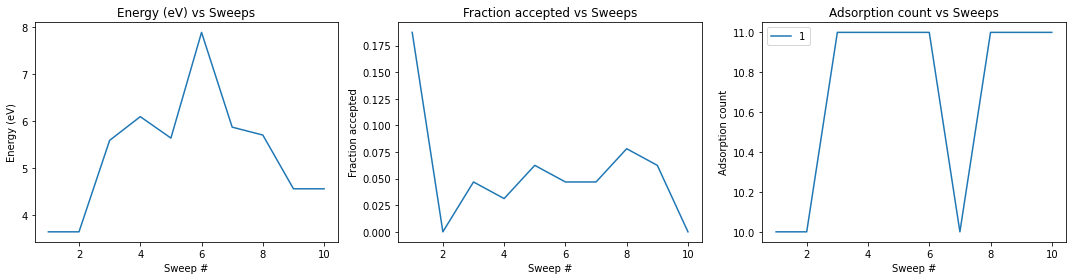

In [19]:
mcmc = MCMC(
    system_settings['surface_name'], 
    calc=nff_calc, 
    canonical=False, 
    testing=False, 
    element=element, 
    adsorbates=list(sampling_settings['chem_pots'].keys()), 
    relax=system_settings['relax_atoms'], 
    relax_steps=system_settings['relax_steps'],
    offset=system_settings['offset'],
    offset_data=system_settings['offset_data'],
    optimizer=system_settings['optimizer']) # relax atoms with manual offset TODO fix this!

start = perf_counter()
# call the main function
# TODO: convert input to sampling settings
mcmc.mcmc_run(
    total_sweeps=sampling_settings['num_sweeps'],
    sweep_size=sampling_settings['sweep_size'],
    start_temp=sampling_settings['temperature'],
    pot=list(sampling_settings['chem_pots'].values()),
    alpha=sampling_settings['alpha'],
    surface=surface
    )
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

In [20]:
sampling_settings['chem_pots'].keys()

dict_keys(['Sr', 'Ti', 'O'])

In [22]:
sampling_settings['chem_pots'].values()

dict_values([-2, 0, 0])

Save structures for later use in latent space clustering or analysis

In [6]:
structures = mcmc.history
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)